# Advanced Lane Finding

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Camera Calibration

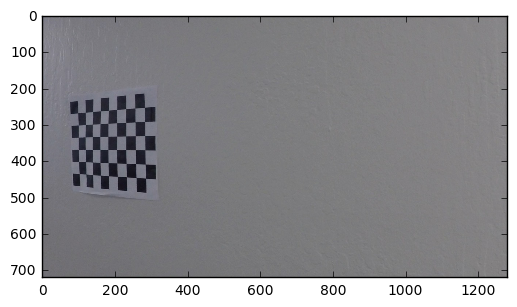

In [2]:
list_images = glob.glob('camera_cal/*')
img_chess = mpimg.imread(list_images[12])
plt.imshow(img_chess)

In [3]:
obj_points = []
img_points = []

nx = 9
ny = 6
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)
for im_path in list_images:
    img = mpimg.imread(im_path)
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    if ret:
        img_points.append(corners)
        obj_points.append(objp)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)


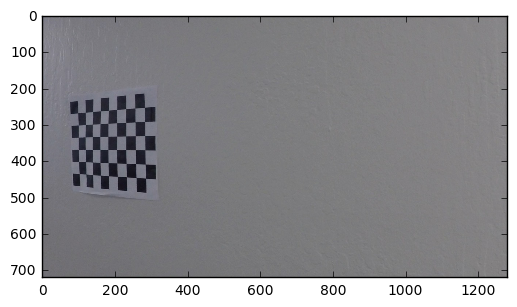

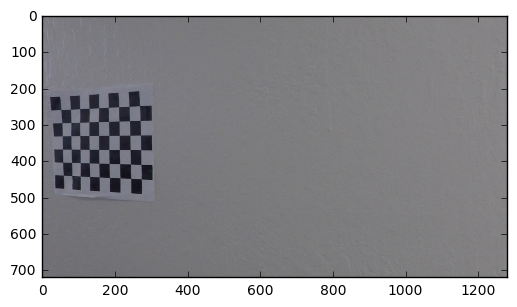

In [4]:
undist = cv2.undistort(img_chess, mtx, dist, None, mtx)
plt.figure()
plt.imshow(img_chess)
plt.figure()
plt.imshow(undist)

## Binarization of images using gradients and color transformation

In [5]:
# functions to get a good mask for an image
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)

    scaled_sobel = np.uint8(255*(abs_sobel/np.max(abs_sobel)))

    binary_output = scaled_sobel > thresh[0]
    binary_output = binary_output*(scaled_sobel < thresh[1])
    return binary_output


def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobel = np.sqrt(np.power(sobelx, 2) + np.power(sobely, 2))
    scaled_sobel = np.uint8(255*(abs_sobel/np.max(abs_sobel)))
    binary_output = scaled_sobel > mag_thresh[0]
    binary_output = binary_output*(scaled_sobel < mag_thresh[1])
    return binary_output


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    angle_sobel = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = angle_sobel > thresh[0]
    binary_output = binary_output*(angle_sobel < thresh[1])
    return binary_output


def filter_l_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_ch = hls[:,:,1]
    binary_output = np.zeros_like(l_ch)
    binary_output[(l_ch > thresh[0]) & (l_ch <= thresh[1])] = 1
    return binary_output


def filter_s_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_ch = hls[:,:,2]
    binary_output = np.zeros_like(s_ch)
    binary_output[(s_ch > thresh[0]) & (s_ch <= thresh[1])] = 1
    return binary_output

In [6]:
road_list_images = glob.glob('test_images/*')
road_list_images = sorted(road_list_images)
print(road_list_images)
img_road = mpimg.imread(road_list_images[-2])

['test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


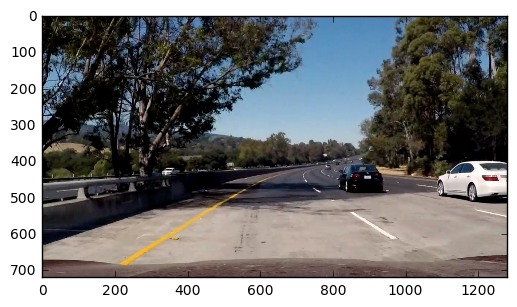

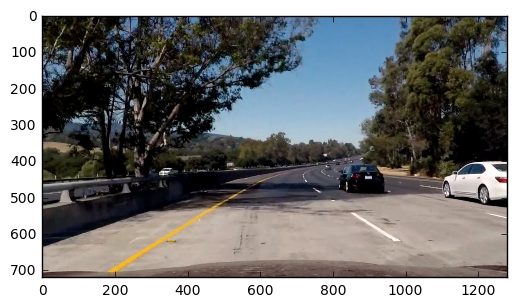

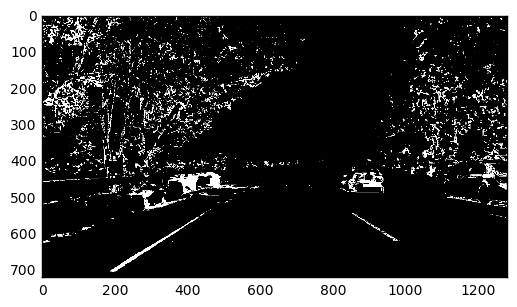

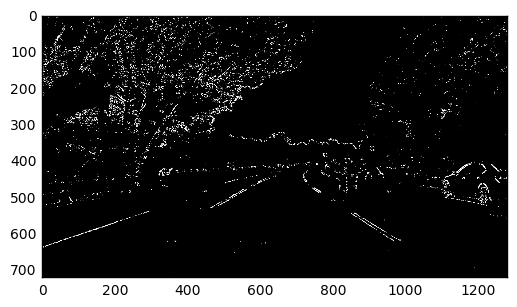

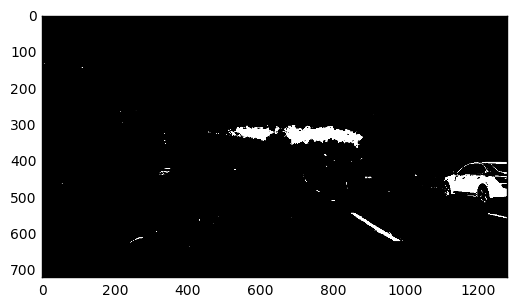

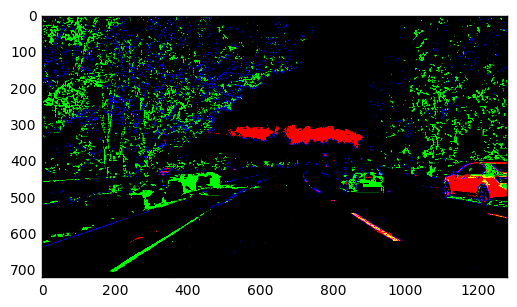

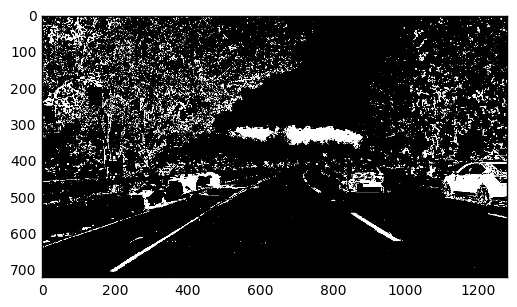

In [58]:
# Apply each of the thresholding functions
ksize=3

img_road_undist = cv2.undistort(img_road, mtx, dist, None, mtx)
gradx = abs_sobel_thresh(img_road_undist, orient='x', sobel_kernel=ksize, thresh=(20, 190))
grady = abs_sobel_thresh(img_road_undist, orient='y', sobel_kernel=ksize, thresh=(30, 190))
mag_binary = mag_thresh(img_road_undist, sobel_kernel=ksize, mag_thresh=(70, 250))
dir_binary = dir_threshold(img_road_undist, sobel_kernel=ksize, thresh=(1.2, 1.4))
l_binary = filter_l_select(img_road_undist, thresh=(190,250))
s_binary = filter_s_select(img_road_undist, thresh=(190,255))


combined = np.zeros_like(dir_binary)
combined[(gradx == 1)&(grady==1) | (s_binary == 1) | (l_binary == 1)] = 1
#combined[(s_binary == 1)] = 1
combined_gray = np.uint8(255*combined)
combined_color = cv2.cvtColor(combined_gray, cv2.COLOR_GRAY2RGB)

rc = np.uint8(np.zeros_like(s_binary))
gc = np.uint8(np.zeros_like(s_binary))
bc = np.uint8(np.zeros_like(s_binary))
bc[(gradx == 1)&(grady==1)] = 1
gc[s_binary==1] = 1
rc[l_binary==1] = 1

color_binary = np.dstack((255*rc, 255*gc, 255*bc))

plt.figure()
plt.imshow(img_road)
plt.figure()
plt.imshow(img_road_undist)
plt.figure()
plt.imshow(gc,cmap='gray')
plt.figure()
plt.imshow(bc,cmap='gray')
plt.figure()
plt.imshow(rc,cmap='gray')
plt.figure()
plt.imshow(color_binary)
plt.figure()
plt.imshow(combined,cmap='gray')

## Perspective transform

* select four points (vertices) to make a perspective transform and get the "bird-eye view"

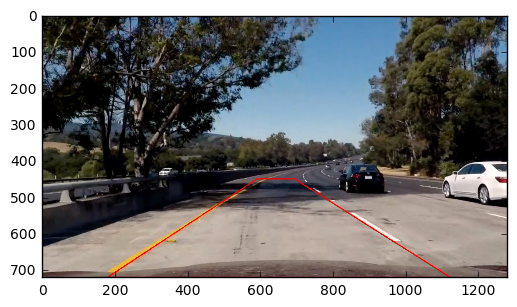

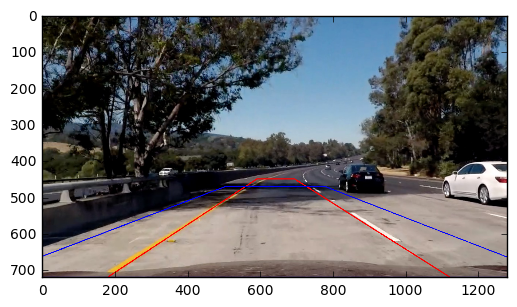

In [59]:
# set and draw trapezoidal section of the road
vertices = np.array([[(180, img_road_undist.shape[0]),
                      (590, 450),
                      (693, 450),
                      (1120, img_road_undist.shape[0])]], dtype=np.int32)
img_example_section = img_road_undist.copy()
section_image_red = cv2.drawContours(img_example_section, vertices, 0, (255,0,0), 2)
section_image_red_copy = section_image_red.copy()

plt.figure()
plt.imshow(section_image_red)

# source points for transformation
blue_srcp = srcp = np.array([[(505, 470),
                              (775, 470),
                              (1420, img_road_undist.shape[0]),
                              (-150, img_road_undist.shape[0])]], dtype=np.int32)

# draw source points
section_image_red_blue = cv2.drawContours(section_image_red_copy, blue_srcp, 0, (0,0,255), 2)
plt.figure()
plt.imshow(section_image_red_blue)

* perform perspective transformation using opencv

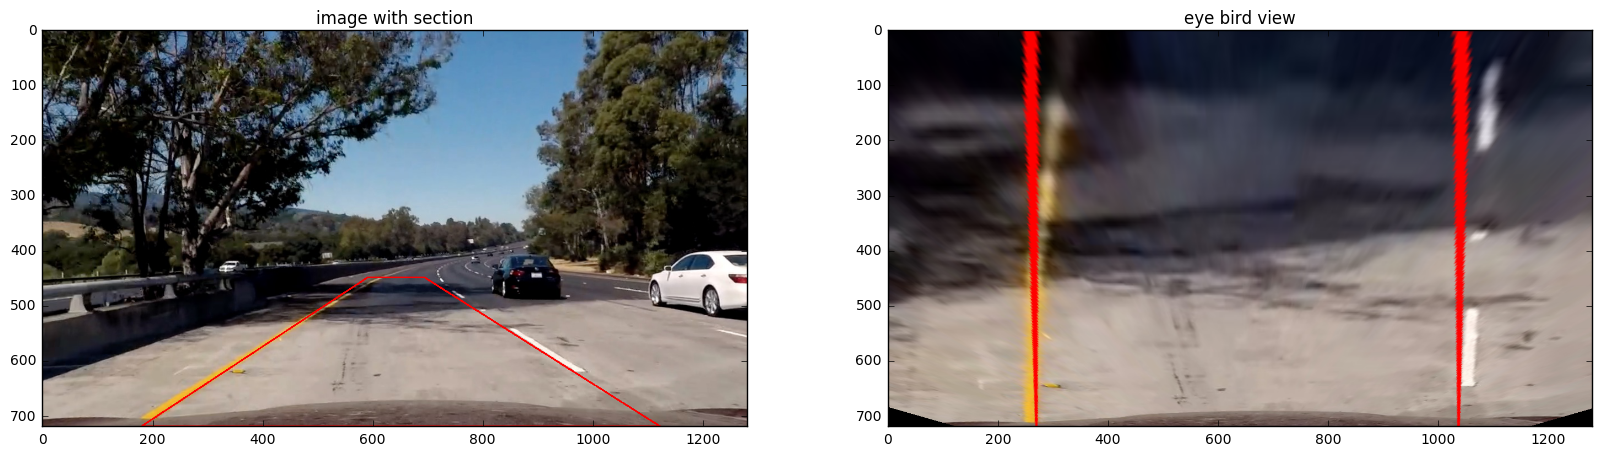

In [60]:
img_size=(img_road_undist.shape[1], img_road_undist.shape[0])
dstp = np.float32([[0, 0],
                    [img_size[0], 0],
                    [img_size[0], img_size[1]],
                    [0, img_size[1]]])
M = cv2.getPerspectiveTransform(np.float32(blue_srcp), dstp)
Minv = cv2.getPerspectiveTransform(dstp, np.float32(blue_srcp))

warped = cv2.warpPerspective(section_image_red, M, img_size)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('image with section')
ax1.imshow(section_image_red)

ax2.set_title('eye bird view')
ax2.imshow(warped, cmap='gray')

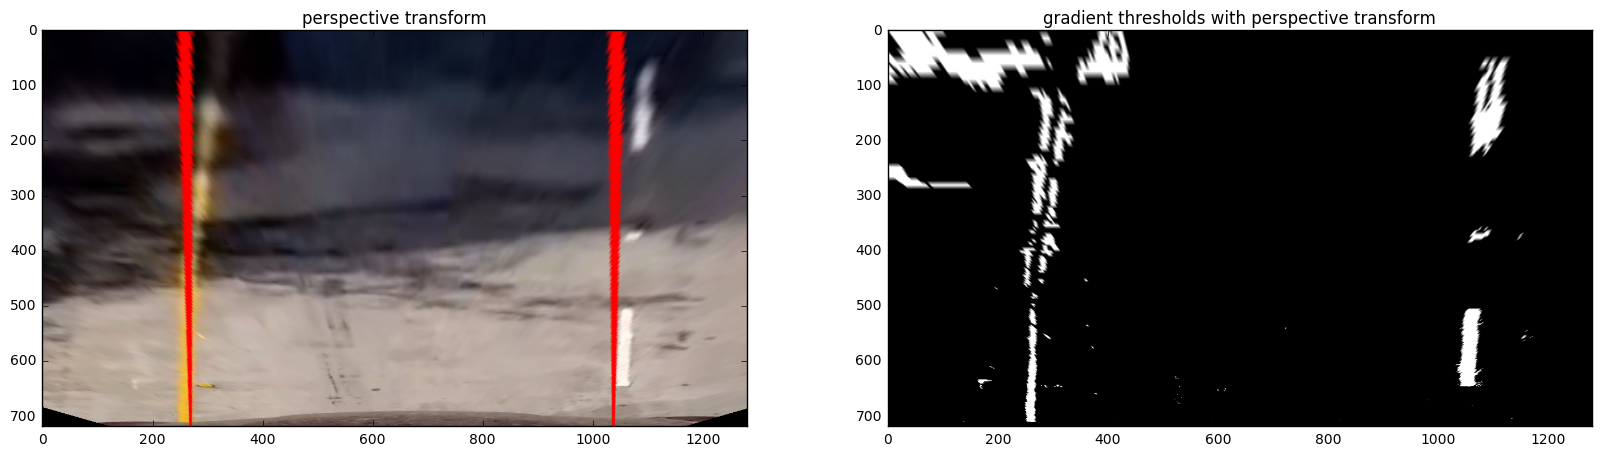

In [61]:
warped_binarized = cv2.warpPerspective(combined_gray, M, img_size)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('perspective transform')
ax1.imshow(warped)

ax2.set_title('gradient thresholds with perspective transform')
ax2.imshow(warped_binarized, cmap='gray')

## Finding Lanes

convolution approach

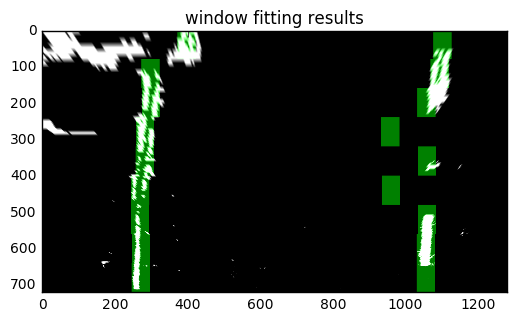

In [11]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

'''from udacity course'''

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center, r_center))

    return window_centroids

warped = warped_binarized.copy()
window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
    # if no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.figure()
plt.imshow(output)
plt.title('window fitting results')
plt.show()

Histogram approach

In [53]:
'''from udacity course'''
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
binary_warped = warped_binarized.copy()

histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

print(len(leftx),len(rightx))

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

29072 14955


719.0

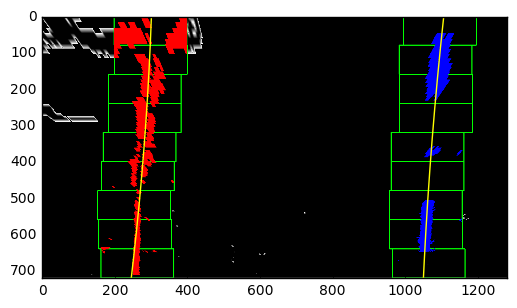

In [40]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
ploty[-1]

29291 29291


(720, 0)

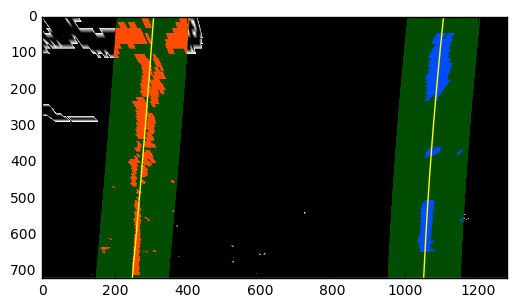

In [52]:
binary_warped = warped_binarized.copy()
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#-----------------------------------------------------------
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
print(len(nonzeroy[left_lane_inds]),len(nonzerox[left_lane_inds]))
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

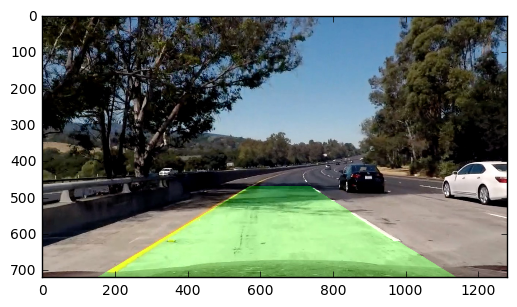

In [42]:
warped = warped_binarized.copy()

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img_road_undist.shape[1], img_road_undist.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img_road_undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

## Estimate curvature

In [43]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

12221.2630175 12080.9434475


In [44]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

3947.52123366 m 3955.50587889 m


## how far is the car of the road

In [77]:
# how far is the car from the middle of the road
x1_meters = left_fitx[-1]*xm_per_pix
x2_meters = right_fitx[-1]*xm_per_pix
my_x = (warped_binarized.shape[1]/2)*xm_per_pix
x_middle_meters = (x1_meters + x2_meters)/2
print(my_x,x_middle_meters)
print(x_middle_meters - my_x)

3.382857142857143 3.43134919778
0.0484920549251


## Visualize results in video

In [90]:
# Define a class to receive the characteristics of each line detection
from IPython.display import HTML
font = cv2.FONT_HERSHEY_SIMPLEX

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [91]:
def process_frame(input_image):
    # pipeline here
    
    # remove distorsion from image
    img_road_undist = cv2.undistort(input_image, mtx, dist, None, mtx)
    
    # threshold image
    gradx = abs_sobel_thresh(img_road_undist, orient='x', sobel_kernel=ksize, thresh=(20, 190))
    grady = abs_sobel_thresh(img_road_undist, orient='y', sobel_kernel=ksize, thresh=(30, 190))
    s_binary = filter_s_select(img_road_undist, thresh=(150,255))
    l_binary = filter_l_select(img_road_undist, thresh=(190,250))
    
    combined = np.zeros_like(s_binary)
    combined[((gradx == 1) & (grady == 1)) | (s_binary == 1) | (l_binary == 1)] = 1
    combined_gray = np.uint8(255*combined)

    # perspective transformation
    warped_binarized = cv2.warpPerspective(combined_gray, M, (img_road_undist.shape[1], img_road_undist.shape[0]))
    
    binary_warped = warped_binarized.copy()

    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    
    # Fit a second order polynomial to each
    #print(len(rightx), len(leftx), lefty, righty)
    if (rightx.shape[0] > 0) and (leftx.shape[0] > 0):
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        color_warp[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        color_warp[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img_road_undist.shape[1], img_road_undist.shape[0]))

        # Combine the result with the original image
        output_image = cv2.addWeighted(img_road_undist, 1, newwarp, 0.3, 0)

        #compute the curvature
        y_eval = np.max(ploty)
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        cv2.putText(output_image,'curvature: {0} m'.format(int(left_curverad)),(10,70), font, 2,(255,255,255),2)
        
        #how far is the car frm the middle of the road
        x1_meters = left_fitx[-1]*xm_per_pix
        x2_meters = right_fitx[-1]*xm_per_pix
        my_x = (warped_binarized.shape[1]/2)*xm_per_pix
        x_middle_meters = (x1_meters + x2_meters)/2
        cv2.putText(output_image,'away from left {0}'.format(my_x - x_middle_meters),(10,200), font, 1.6,(255,255,255),2)
    else:
        output_image = input_image.copy()
    return output_image

3.32896051886 3.382857142857143


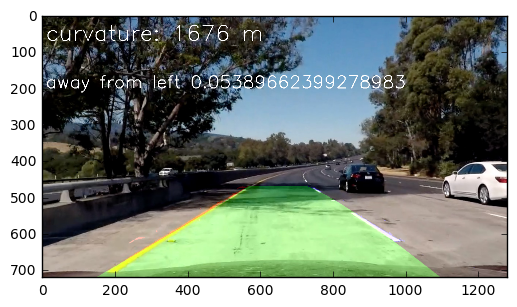

In [92]:
out = process_frame(img_road)
plt.figure()
plt.imshow(out)

In [93]:
project_output = 'out_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame)
#%time white_clip.write_videofile(project_output, audio=False)
white_clip.write_videofile(project_output, audio=False)

3.86168158669 3.382857142857143
[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


  0%|          | 1/1261 [00:00<03:41,  5.68it/s]

3.86168158669 3.382857142857143


  0%|          | 2/1261 [00:00<03:45,  5.58it/s]

3.86820061279 3.382857142857143


  0%|          | 3/1261 [00:00<03:41,  5.68it/s]

3.85349912006 3.382857142857143


  0%|          | 4/1261 [00:00<03:40,  5.70it/s]

3.83600158379 3.382857142857143


  0%|          | 5/1261 [00:00<03:36,  5.80it/s]

3.83780683026 3.382857142857143


  0%|          | 6/1261 [00:01<03:34,  5.85it/s]

3.84815682265 3.382857142857143


  1%|          | 7/1261 [00:01<03:31,  5.93it/s]

3.85296945638 3.382857142857143


  1%|          | 8/1261 [00:01<03:31,  5.93it/s]

3.83343261944 3.382857142857143


  1%|          | 9/1261 [00:01<03:32,  5.89it/s]

3.8099270211 3.382857142857143


  1%|          | 10/1261 [00:01<03:37,  5.76it/s]

3.82925447775 3.382857142857143


  1%|          | 11/1261 [00:01<03:33,  5.84it/s]

3.86055066272 3.382857142857143


  1%|          | 12/1261 [00:02<03:33,  5.86it/s]

3.87008005447 3.382857142857143


  1%|          | 13/1261 [00:02<03:38,  5.72it/s]

3.89388543109 3.382857142857143


  1%|          | 14/1261 [00:02<03:43,  5.59it/s]

3.9169424283 3.382857142857143


  1%|          | 15/1261 [00:02<03:39,  5.68it/s]

3.90200240893 3.382857142857143


  1%|▏         | 16/1261 [00:02<03:38,  5.71it/s]

3.85432928717 3.382857142857143


  1%|▏         | 17/1261 [00:02<03:38,  5.70it/s]

3.84388548911 3.382857142857143


  1%|▏         | 18/1261 [00:03<03:36,  5.73it/s]

3.8532051985 3.382857142857143


  2%|▏         | 19/1261 [00:03<03:36,  5.73it/s]

3.84873425398 3.382857142857143


  2%|▏         | 20/1261 [00:03<03:37,  5.71it/s]

3.84406171272 3.382857142857143


  2%|▏         | 21/1261 [00:03<03:37,  5.69it/s]

3.80875914478 3.382857142857143


  2%|▏         | 22/1261 [00:03<03:41,  5.59it/s]

3.77501039299 3.382857142857143


  2%|▏         | 23/1261 [00:04<03:40,  5.61it/s]

3.75606660483 3.382857142857143


  2%|▏         | 24/1261 [00:04<03:38,  5.65it/s]

3.78772052102 3.382857142857143


  2%|▏         | 25/1261 [00:04<03:36,  5.71it/s]

3.79235455103 3.382857142857143


  2%|▏         | 26/1261 [00:04<03:37,  5.68it/s]

3.79985756349 3.382857142857143


  2%|▏         | 27/1261 [00:04<03:39,  5.63it/s]

3.81163651838 3.382857142857143


  2%|▏         | 28/1261 [00:04<03:38,  5.65it/s]

3.80531574962 3.382857142857143


  2%|▏         | 29/1261 [00:05<03:39,  5.61it/s]

3.79554428728 3.382857142857143


  2%|▏         | 30/1261 [00:05<03:36,  5.68it/s]

3.78987668851 3.382857142857143


  2%|▏         | 31/1261 [00:05<03:36,  5.68it/s]

3.77941118546 3.382857142857143


  3%|▎         | 32/1261 [00:05<03:39,  5.60it/s]

3.77513913304 3.382857142857143


  3%|▎         | 33/1261 [00:05<03:40,  5.56it/s]

3.77836631116 3.382857142857143


  3%|▎         | 34/1261 [00:05<03:40,  5.56it/s]

3.72553613062 3.382857142857143


  3%|▎         | 35/1261 [00:06<03:42,  5.52it/s]

3.7311613979 3.382857142857143


  3%|▎         | 36/1261 [00:06<03:43,  5.48it/s]

3.7755425266 3.382857142857143


  3%|▎         | 37/1261 [00:06<03:40,  5.56it/s]

3.7838892872 3.382857142857143


  3%|▎         | 38/1261 [00:06<03:37,  5.63it/s]

3.82745947379 3.382857142857143


  3%|▎         | 39/1261 [00:06<03:31,  5.77it/s]

3.82648713794 3.382857142857143


  3%|▎         | 40/1261 [00:07<03:28,  5.86it/s]

3.81024189988 3.382857142857143


  3%|▎         | 41/1261 [00:07<03:27,  5.87it/s]

3.80772165521 3.382857142857143


  3%|▎         | 42/1261 [00:07<03:27,  5.87it/s]

3.78760004861 3.382857142857143


  3%|▎         | 43/1261 [00:07<03:33,  5.70it/s]

3.802813923 3.382857142857143


  4%|▎         | 45/1261 [00:07<03:45,  5.38it/s]

3.80611603504 3.382857142857143
3.81436670858 3.382857142857143


  4%|▎         | 47/1261 [00:08<03:35,  5.62it/s]

3.7926812625 3.382857142857143
3.74549546471 3.382857142857143


  4%|▍         | 49/1261 [00:08<03:41,  5.47it/s]

3.76307322566 3.382857142857143
3.78939444599 3.382857142857143


  4%|▍         | 51/1261 [00:09<03:48,  5.30it/s]

3.80416487254 3.382857142857143
3.83314820557 3.382857142857143


  4%|▍         | 53/1261 [00:09<03:51,  5.21it/s]

3.84986503424 3.382857142857143
3.83424443536 3.382857142857143


  4%|▍         | 55/1261 [00:09<03:46,  5.33it/s]

3.821439405 3.382857142857143
3.80839851416 3.382857142857143


  5%|▍         | 57/1261 [00:10<03:46,  5.31it/s]

3.81522923045 3.382857142857143
3.8207639454 3.382857142857143


  5%|▍         | 59/1261 [00:10<03:48,  5.26it/s]

3.81333031101 3.382857142857143
3.72508345969 3.382857142857143


  5%|▍         | 61/1261 [00:10<03:39,  5.48it/s]

3.76338204317 3.382857142857143
3.77459066913 3.382857142857143


  5%|▍         | 63/1261 [00:11<03:39,  5.47it/s]

3.8032400504 3.382857142857143
3.83063272959 3.382857142857143


  5%|▌         | 65/1261 [00:11<03:41,  5.40it/s]

3.80106617721 3.382857142857143
3.78787967958 3.382857142857143


  5%|▌         | 67/1261 [00:12<03:33,  5.59it/s]

3.74314269425 3.382857142857143
3.72682141365 3.382857142857143


  5%|▌         | 69/1261 [00:12<03:36,  5.52it/s]

3.72767666602 3.382857142857143
3.71997207156 3.382857142857143


  6%|▌         | 70/1261 [00:12<03:41,  5.38it/s]

3.71324472444 3.382857142857143
3.64155037364 3.382857142857143


  6%|▌         | 73/1261 [00:13<03:42,  5.34it/s]

3.64699403572 3.382857142857143
3.6633619113 3.382857142857143


  6%|▌         | 75/1261 [00:13<03:43,  5.30it/s]

3.69610029724 3.382857142857143
3.69691101944 3.382857142857143


  6%|▌         | 76/1261 [00:13<03:45,  5.26it/s]

3.7119169534 3.382857142857143


  6%|▌         | 78/1261 [00:14<03:49,  5.15it/s]

3.71972196904 3.382857142857143
3.71371634668 3.382857142857143


  6%|▋         | 80/1261 [00:14<03:44,  5.25it/s]

3.69613540951 3.382857142857143
3.68039643614 3.382857142857143


  7%|▋         | 82/1261 [00:14<03:34,  5.49it/s]

3.67248435618 3.382857142857143
3.67230349673 3.382857142857143


  7%|▋         | 84/1261 [00:15<03:30,  5.60it/s]

3.66636757343 3.382857142857143
3.67032590136 3.382857142857143


  7%|▋         | 86/1261 [00:15<03:34,  5.47it/s]

3.62361901671 3.382857142857143
3.60411018717 3.382857142857143


  7%|▋         | 88/1261 [00:15<03:37,  5.39it/s]

3.63858339587 3.382857142857143
3.67394059026 3.382857142857143


  7%|▋         | 90/1261 [00:16<03:39,  5.33it/s]

3.69146487237 3.382857142857143
3.67528800143 3.382857142857143


  7%|▋         | 92/1261 [00:16<03:43,  5.22it/s]

3.66042899236 3.382857142857143
3.63763045593 3.382857142857143


  7%|▋         | 94/1261 [00:17<03:39,  5.32it/s]

3.64225796975 3.382857142857143
3.64420115017 3.382857142857143


  8%|▊         | 96/1261 [00:17<03:36,  5.39it/s]

3.63987267728 3.382857142857143
3.58810152755 3.382857142857143


  8%|▊         | 98/1261 [00:17<03:41,  5.25it/s]

3.57663220653 3.382857142857143
3.59954112014 3.382857142857143


  8%|▊         | 100/1261 [00:18<03:33,  5.43it/s]

3.62153886856 3.382857142857143
3.63377902454 3.382857142857143


  8%|▊         | 102/1261 [00:18<03:34,  5.40it/s]

3.65479147658 3.382857142857143
3.66773568789 3.382857142857143


  8%|▊         | 104/1261 [00:18<03:33,  5.43it/s]

3.66304068194 3.382857142857143
3.6646495544 3.382857142857143


  8%|▊         | 106/1261 [00:19<03:30,  5.50it/s]

3.66701565544 3.382857142857143
3.67005352402 3.382857142857143


  9%|▊         | 108/1261 [00:19<03:35,  5.35it/s]

3.68239856847 3.382857142857143
3.69394402745 3.382857142857143


  9%|▊         | 110/1261 [00:20<03:33,  5.39it/s]

3.70953485464 3.382857142857143
3.65529885787 3.382857142857143


  9%|▉         | 112/1261 [00:20<03:31,  5.42it/s]

3.67277381806 3.382857142857143
3.68738144904 3.382857142857143


  9%|▉         | 114/1261 [00:20<03:33,  5.38it/s]

3.7113078568 3.382857142857143
3.74202976528 3.382857142857143


  9%|▉         | 116/1261 [00:21<03:37,  5.26it/s]

3.75712139453 3.382857142857143
3.73722132935 3.382857142857143


  9%|▉         | 118/1261 [00:21<03:28,  5.49it/s]

3.73354310478 3.382857142857143
3.72058825052 3.382857142857143


 10%|▉         | 120/1261 [00:21<03:35,  5.28it/s]

3.73338973807 3.382857142857143
3.73807770987 3.382857142857143


 10%|▉         | 122/1261 [00:22<03:33,  5.35it/s]

3.73873974306 3.382857142857143
3.68207071458 3.382857142857143


 10%|▉         | 124/1261 [00:22<03:29,  5.42it/s]

3.70983154315 3.382857142857143
3.75480669569 3.382857142857143


 10%|▉         | 126/1261 [00:23<03:33,  5.31it/s]

3.77010033768 3.382857142857143
3.81199848622 3.382857142857143


 10%|█         | 128/1261 [00:23<03:34,  5.28it/s]

3.81319339629 3.382857142857143
3.81236411714 3.382857142857143


 10%|█         | 130/1261 [00:23<03:33,  5.29it/s]

3.78037039856 3.382857142857143
3.77605414282 3.382857142857143


 10%|█         | 132/1261 [00:24<03:35,  5.23it/s]

3.79808904032 3.382857142857143
3.80255530463 3.382857142857143


 11%|█         | 134/1261 [00:24<03:32,  5.30it/s]

3.80694493216 3.382857142857143
3.73864847747 3.382857142857143


 11%|█         | 136/1261 [00:24<03:31,  5.31it/s]

3.76300656424 3.382857142857143
3.80278734947 3.382857142857143


 11%|█         | 138/1261 [00:25<03:32,  5.27it/s]

3.81569762812 3.382857142857143
3.82880961964 3.382857142857143


 11%|█         | 140/1261 [00:25<03:25,  5.46it/s]

3.85875506275 3.382857142857143
3.86533070202 3.382857142857143


 11%|█         | 141/1261 [00:25<03:31,  5.30it/s]

3.85288111642 3.382857142857143
3.83589967294 3.382857142857143


 11%|█▏        | 144/1261 [00:26<03:29,  5.34it/s]

3.81791858012 3.382857142857143
3.81756955103 3.382857142857143


 12%|█▏        | 146/1261 [00:26<03:28,  5.35it/s]

3.81526150009 3.382857142857143
3.8136637502 3.382857142857143


 12%|█▏        | 148/1261 [00:27<03:29,  5.32it/s]

3.76573785127 3.382857142857143
3.80936687759 3.382857142857143


 12%|█▏        | 150/1261 [00:27<03:30,  5.28it/s]

3.82206665804 3.382857142857143
3.8294197662 3.382857142857143


 12%|█▏        | 152/1261 [00:27<03:28,  5.32it/s]

3.85473966842 3.382857142857143
3.8610359434 3.382857142857143


 12%|█▏        | 154/1261 [00:28<03:29,  5.29it/s]

3.83267675478 3.382857142857143
3.8260520422 3.382857142857143


 12%|█▏        | 156/1261 [00:28<03:25,  5.39it/s]

3.79656200042 3.382857142857143
3.79330784514 3.382857142857143


 13%|█▎        | 158/1261 [00:29<03:20,  5.51it/s]

3.79007969965 3.382857142857143
3.77447065995 3.382857142857143


 13%|█▎        | 159/1261 [00:29<03:18,  5.55it/s]

3.70158878086 3.382857142857143
3.70823201463 3.382857142857143


 13%|█▎        | 162/1261 [00:29<03:27,  5.30it/s]

3.73827657394 3.382857142857143
3.77545130047 3.382857142857143


 13%|█▎        | 164/1261 [00:30<03:30,  5.21it/s]

3.76733058173 3.382857142857143
3.8197789157 3.382857142857143


 13%|█▎        | 166/1261 [00:30<03:24,  5.35it/s]

3.80662741979 3.382857142857143
3.78327787166 3.382857142857143


 13%|█▎        | 168/1261 [00:30<03:23,  5.38it/s]

3.74603168159 3.382857142857143
3.75753830033 3.382857142857143


 13%|█▎        | 170/1261 [00:31<03:21,  5.41it/s]

3.75487347913 3.382857142857143
3.74939385389 3.382857142857143


 14%|█▎        | 172/1261 [00:31<03:24,  5.32it/s]

3.73616189341 3.382857142857143
3.66336193375 3.382857142857143


 14%|█▍        | 174/1261 [00:32<03:20,  5.43it/s]

3.65391074619 3.382857142857143
3.68503046165 3.382857142857143


 14%|█▍        | 176/1261 [00:32<03:21,  5.39it/s]

3.70409227751 3.382857142857143
3.73534353491 3.382857142857143


 14%|█▍        | 178/1261 [00:32<03:23,  5.32it/s]

3.72193058845 3.382857142857143
3.72066235001 3.382857142857143


 14%|█▍        | 180/1261 [00:33<03:24,  5.27it/s]

3.71383541176 3.382857142857143
3.69848271432 3.382857142857143


 14%|█▍        | 182/1261 [00:33<03:21,  5.37it/s]

3.70658109684 3.382857142857143
3.70804969232 3.382857142857143


 15%|█▍        | 184/1261 [00:33<03:19,  5.39it/s]

3.69017566195 3.382857142857143
3.66404341756 3.382857142857143


 15%|█▍        | 186/1261 [00:34<03:17,  5.43it/s]

3.69599019512 3.382857142857143
3.73288276852 3.382857142857143


 15%|█▍        | 187/1261 [00:34<03:19,  5.39it/s]

3.74319460099 3.382857142857143


 15%|█▍        | 188/1261 [00:34<03:26,  5.21it/s]

3.78249431587 3.382857142857143


 15%|█▍        | 189/1261 [00:34<03:30,  5.10it/s]

3.76965158374 3.382857142857143
3.72248504072 3.382857142857143


 15%|█▌        | 192/1261 [00:35<03:28,  5.13it/s]

3.73734859363 3.382857142857143
3.75583592876 3.382857142857143


 15%|█▌        | 194/1261 [00:35<03:20,  5.31it/s]

3.76668612337 3.382857142857143
3.75822124086 3.382857142857143


 16%|█▌        | 196/1261 [00:36<03:17,  5.39it/s]

3.7543538847 3.382857142857143
3.70806900706 3.382857142857143


 16%|█▌        | 198/1261 [00:36<03:18,  5.36it/s]

3.71444443249 3.382857142857143
3.72457394659 3.382857142857143


 16%|█▌        | 200/1261 [00:37<03:15,  5.44it/s]

3.71916443937 3.382857142857143
3.7433966839 3.382857142857143


 16%|█▌        | 202/1261 [00:37<03:16,  5.40it/s]

3.75209342585 3.382857142857143
3.77185213027 3.382857142857143


 16%|█▌        | 204/1261 [00:37<03:16,  5.39it/s]

3.76087474667 3.382857142857143
3.74525901074 3.382857142857143


 16%|█▋        | 206/1261 [00:38<03:11,  5.49it/s]

3.7292323021 3.382857142857143
3.73430468256 3.382857142857143


 16%|█▋        | 207/1261 [00:38<03:10,  5.53it/s]

3.73514207751 3.382857142857143
3.66457897636 3.382857142857143


 17%|█▋        | 210/1261 [00:38<03:16,  5.35it/s]

3.67730675403 3.382857142857143
3.69490382527 3.382857142857143


 17%|█▋        | 212/1261 [00:39<03:07,  5.60it/s]

3.70727482636 3.382857142857143
3.72081440363 3.382857142857143


 17%|█▋        | 213/1261 [00:39<03:05,  5.66it/s]

3.74579104142 3.382857142857143


 17%|█▋        | 215/1261 [00:39<03:12,  5.43it/s]

3.75965045171 3.382857142857143
3.7415537737 3.382857142857143


 17%|█▋        | 217/1261 [00:40<03:08,  5.54it/s]

3.72065999276 3.382857142857143
3.70135433835 3.382857142857143


 17%|█▋        | 219/1261 [00:40<03:04,  5.64it/s]

3.69470420157 3.382857142857143
3.6956267323 3.382857142857143


 18%|█▊        | 221/1261 [00:40<03:12,  5.41it/s]

3.69536680491 3.382857142857143
3.66443572322 3.382857142857143


 18%|█▊        | 223/1261 [00:41<03:14,  5.33it/s]

3.65297844804 3.382857142857143
3.67311636981 3.382857142857143


 18%|█▊        | 224/1261 [00:41<03:18,  5.21it/s]

3.6927916755 3.382857142857143


 18%|█▊        | 226/1261 [00:41<03:22,  5.12it/s]

3.71797598238 3.382857142857143
3.7278617015 3.382857142857143


 18%|█▊        | 228/1261 [00:42<03:15,  5.28it/s]

3.7045699364 3.382857142857143
3.68227532893 3.382857142857143


 18%|█▊        | 230/1261 [00:42<03:16,  5.23it/s]

3.65898635746 3.382857142857143
3.64788718919 3.382857142857143


 18%|█▊        | 232/1261 [00:42<03:15,  5.27it/s]

3.64177951992 3.382857142857143
3.63211701257 3.382857142857143


 19%|█▊        | 234/1261 [00:43<03:14,  5.28it/s]

3.61708824618 3.382857142857143
3.54720212918 3.382857142857143


 19%|█▊        | 235/1261 [00:43<03:11,  5.35it/s]

3.56663077238 3.382857142857143


 19%|█▉        | 237/1261 [00:43<03:09,  5.39it/s]

3.59202046003 3.382857142857143
3.61305592287 3.382857142857143


 19%|█▉        | 238/1261 [00:44<03:12,  5.32it/s]

3.62069935881 3.382857142857143


 19%|█▉        | 239/1261 [00:44<03:17,  5.18it/s]

3.60466727169 3.382857142857143
3.56650777699 3.382857142857143


 19%|█▉        | 242/1261 [00:44<03:13,  5.27it/s]

3.5660788015 3.382857142857143
3.5714408699 3.382857142857143


 19%|█▉        | 244/1261 [00:45<03:14,  5.22it/s]

3.56844653838 3.382857142857143
3.56103532178 3.382857142857143


 20%|█▉        | 246/1261 [00:45<03:09,  5.36it/s]

3.50280113364 3.382857142857143
3.50463043156 3.382857142857143


 20%|█▉        | 248/1261 [00:45<03:07,  5.39it/s]

3.53427061442 3.382857142857143
3.54611468642 3.382857142857143


 20%|█▉        | 249/1261 [00:46<03:04,  5.48it/s]

3.55311285945 3.382857142857143


 20%|█▉        | 250/1261 [00:46<03:11,  5.28it/s]

3.56876353144 3.382857142857143


 20%|█▉        | 252/1261 [00:46<03:11,  5.26it/s]

3.56004291236 3.382857142857143
3.53484466625 3.382857142857143


 20%|██        | 254/1261 [00:47<03:11,  5.26it/s]

3.53634583957 3.382857142857143
3.54228670584 3.382857142857143


 20%|██        | 256/1261 [00:47<03:12,  5.22it/s]

3.54820947898 3.382857142857143
3.5458285742 3.382857142857143


 20%|██        | 257/1261 [00:47<03:13,  5.18it/s]

3.47466065077 3.382857142857143


 21%|██        | 259/1261 [00:48<03:11,  5.24it/s]

3.51208094966 3.382857142857143
3.51240112577 3.382857142857143


 21%|██        | 261/1261 [00:48<03:09,  5.28it/s]

3.54756020883 3.382857142857143
3.56110114756 3.382857142857143


 21%|██        | 263/1261 [00:48<03:04,  5.41it/s]

3.58864335956 3.382857142857143
3.58873131062 3.382857142857143


 21%|██        | 265/1261 [00:49<03:02,  5.44it/s]

3.58250782299 3.382857142857143
3.55639841836 3.382857142857143


 21%|██        | 267/1261 [00:49<03:01,  5.49it/s]

3.56020951357 3.382857142857143
3.56663697694 3.382857142857143


 21%|██▏       | 269/1261 [00:49<03:02,  5.43it/s]

3.56823618908 3.382857142857143
3.56914010047 3.382857142857143


 21%|██▏       | 271/1261 [00:50<03:04,  5.38it/s]

3.53313534242 3.382857142857143
3.55342756117 3.382857142857143


 22%|██▏       | 273/1261 [00:50<02:59,  5.50it/s]

3.58116449154 3.382857142857143
3.60588531312 3.382857142857143


 22%|██▏       | 275/1261 [00:51<02:56,  5.59it/s]

3.65271051276 3.382857142857143
3.64148484442 3.382857142857143


 22%|██▏       | 277/1261 [00:51<02:54,  5.64it/s]

3.61815188387 3.382857142857143
3.61002699607 3.382857142857143


 22%|██▏       | 279/1261 [00:51<02:54,  5.63it/s]

3.61057428823 3.382857142857143
3.61351922525 3.382857142857143


 22%|██▏       | 281/1261 [00:52<03:05,  5.27it/s]

3.60845082067 3.382857142857143
3.54343863024 3.382857142857143


 22%|██▏       | 282/1261 [00:52<03:13,  5.07it/s]

3.57135641603 3.382857142857143


 22%|██▏       | 283/1261 [00:52<03:22,  4.84it/s]

3.62800289669 3.382857142857143


 23%|██▎       | 284/1261 [00:52<03:33,  4.57it/s]

3.64010700923 3.382857142857143


 23%|██▎       | 285/1261 [00:53<03:38,  4.46it/s]

3.66730542736 3.382857142857143


 23%|██▎       | 286/1261 [00:53<03:39,  4.44it/s]

3.69453050805 3.382857142857143


 23%|██▎       | 287/1261 [00:53<03:37,  4.48it/s]

3.70396471973 3.382857142857143
3.69435408407 3.382857142857143


 23%|██▎       | 289/1261 [00:53<03:20,  4.84it/s]

3.67761131094 3.382857142857143


 23%|██▎       | 290/1261 [00:54<03:31,  4.60it/s]

3.68031091041 3.382857142857143


 23%|██▎       | 291/1261 [00:54<03:50,  4.21it/s]

3.68684835734 3.382857142857143


 23%|██▎       | 292/1261 [00:54<03:58,  4.06it/s]

3.68864289383 3.382857142857143


 23%|██▎       | 293/1261 [00:55<04:23,  3.67it/s]

3.64391948074 3.382857142857143


 23%|██▎       | 294/1261 [00:55<04:07,  3.91it/s]

3.66764599818 3.382857142857143


 23%|██▎       | 295/1261 [00:55<03:54,  4.11it/s]

3.68315087024 3.382857142857143


 24%|██▎       | 297/1261 [00:55<03:29,  4.60it/s]

3.70923701049 3.382857142857143
3.71586093153 3.382857142857143


 24%|██▎       | 299/1261 [00:56<03:14,  4.95it/s]

3.74628666067 3.382857142857143
3.73281157381 3.382857142857143


 24%|██▍       | 301/1261 [00:56<03:10,  5.04it/s]

3.71997778803 3.382857142857143
3.7032537032 3.382857142857143


 24%|██▍       | 303/1261 [00:56<03:05,  5.15it/s]

3.69949464602 3.382857142857143
3.70228134363 3.382857142857143


 24%|██▍       | 305/1261 [00:57<03:01,  5.28it/s]

3.70081688951 3.382857142857143
3.71779648892 3.382857142857143


 24%|██▍       | 307/1261 [00:57<03:00,  5.27it/s]

3.67552064388 3.382857142857143
3.68997640736 3.382857142857143


 24%|██▍       | 308/1261 [00:57<03:04,  5.16it/s]

3.73221149791 3.382857142857143


 25%|██▍       | 309/1261 [00:58<03:10,  5.01it/s]

3.73833346286 3.382857142857143


 25%|██▍       | 310/1261 [00:58<03:17,  4.81it/s]

3.79602153368 3.382857142857143
3.76417895646 3.382857142857143


 25%|██▍       | 313/1261 [00:58<03:08,  5.04it/s]

3.73304451269 3.382857142857143
3.72958163471 3.382857142857143


 25%|██▍       | 314/1261 [00:59<03:08,  5.03it/s]

3.73110037849 3.382857142857143


 25%|██▌       | 316/1261 [00:59<03:07,  5.04it/s]

3.73054187361 3.382857142857143
3.72632058661 3.382857142857143


 25%|██▌       | 318/1261 [00:59<03:00,  5.22it/s]

3.67962865158 3.382857142857143
3.69953881035 3.382857142857143


 25%|██▌       | 320/1261 [01:00<02:55,  5.36it/s]

3.69215314285 3.382857142857143
3.71738762082 3.382857142857143


 26%|██▌       | 322/1261 [01:00<02:58,  5.26it/s]

3.73433278388 3.382857142857143
3.75510237055 3.382857142857143


 26%|██▌       | 324/1261 [01:01<02:58,  5.24it/s]

3.74613519797 3.382857142857143
3.73987957539 3.382857142857143


 26%|██▌       | 326/1261 [01:01<02:56,  5.29it/s]

3.71848043012 3.382857142857143
3.72663553918 3.382857142857143


 26%|██▌       | 328/1261 [01:01<03:06,  5.00it/s]

3.72792674952 3.382857142857143
3.72221535097 3.382857142857143


 26%|██▌       | 330/1261 [01:02<02:58,  5.22it/s]

3.73744922845 3.382857142857143
3.67497687939 3.382857142857143


 26%|██▋       | 332/1261 [01:02<03:06,  4.97it/s]

3.70231799808 3.382857142857143
3.72485446464 3.382857142857143


 26%|██▋       | 334/1261 [01:03<02:56,  5.24it/s]

3.73638842016 3.382857142857143
3.73028258365 3.382857142857143


 27%|██▋       | 336/1261 [01:03<02:53,  5.33it/s]

3.74685252951 3.382857142857143
3.7423436228 3.382857142857143


 27%|██▋       | 338/1261 [01:03<02:53,  5.31it/s]

3.72546513008 3.382857142857143
3.73799389838 3.382857142857143


 27%|██▋       | 340/1261 [01:04<02:55,  5.25it/s]

3.73920459415 3.382857142857143
3.74003087035 3.382857142857143


 27%|██▋       | 342/1261 [01:04<02:48,  5.44it/s]

3.71131819622 3.382857142857143
3.73162720067 3.382857142857143


 27%|██▋       | 344/1261 [01:04<02:49,  5.42it/s]

3.73614277404 3.382857142857143
3.74594610218 3.382857142857143


 27%|██▋       | 346/1261 [01:05<02:49,  5.41it/s]

3.75834442324 3.382857142857143
3.78388137595 3.382857142857143


 28%|██▊       | 348/1261 [01:05<02:48,  5.42it/s]

3.78087782446 3.382857142857143
3.76921065641 3.382857142857143


 28%|██▊       | 349/1261 [01:05<02:50,  5.36it/s]

3.74846068002 3.382857142857143


 28%|██▊       | 350/1261 [01:06<03:02,  4.98it/s]

3.75039310036 3.382857142857143


 28%|██▊       | 352/1261 [01:06<03:06,  4.86it/s]

3.75167259885 3.382857142857143
3.74540678389 3.382857142857143


 28%|██▊       | 354/1261 [01:06<03:03,  4.93it/s]

3.73448368356 3.382857142857143
3.67858011115 3.382857142857143


 28%|██▊       | 355/1261 [01:07<03:01,  4.99it/s]

3.69505354567 3.382857142857143


 28%|██▊       | 356/1261 [01:07<03:18,  4.55it/s]

3.70811892952 3.382857142857143


 28%|██▊       | 357/1261 [01:07<03:22,  4.46it/s]

3.71386409474 3.382857142857143


 28%|██▊       | 358/1261 [01:07<03:37,  4.16it/s]

3.74586314812 3.382857142857143


 28%|██▊       | 359/1261 [01:08<03:34,  4.21it/s]

3.75612027285 3.382857142857143
3.74472822159 3.382857142857143


 29%|██▊       | 362/1261 [01:08<02:58,  5.03it/s]

3.72332555556 3.382857142857143
3.73455470059 3.382857142857143


 29%|██▉       | 364/1261 [01:09<02:54,  5.14it/s]

3.74751222309 3.382857142857143
3.74592885994 3.382857142857143


 29%|██▉       | 366/1261 [01:09<02:54,  5.11it/s]

3.71586523579 3.382857142857143
3.72549737448 3.382857142857143


 29%|██▉       | 368/1261 [01:09<02:51,  5.20it/s]

3.75427029272 3.382857142857143
3.76519482872 3.382857142857143


 29%|██▉       | 370/1261 [01:10<02:48,  5.28it/s]

3.79118776466 3.382857142857143
3.80997897433 3.382857142857143


 30%|██▉       | 372/1261 [01:10<02:46,  5.35it/s]

3.79557763694 3.382857142857143
3.77374977487 3.382857142857143


 30%|██▉       | 374/1261 [01:10<02:45,  5.35it/s]

3.74614864312 3.382857142857143
3.74000156534 3.382857142857143


 30%|██▉       | 376/1261 [01:11<02:42,  5.46it/s]

3.72898161984 3.382857142857143
3.71193894274 3.382857142857143


 30%|██▉       | 378/1261 [01:11<02:42,  5.42it/s]

3.67667315709 3.382857142857143
3.68322090244 3.382857142857143


 30%|███       | 380/1261 [01:12<02:44,  5.37it/s]

3.69159819616 3.382857142857143
3.70423791512 3.382857142857143


 30%|███       | 382/1261 [01:12<02:43,  5.39it/s]

3.7059763116 3.382857142857143
3.74524389598 3.382857142857143


 30%|███       | 384/1261 [01:12<02:40,  5.46it/s]

3.72696766546 3.382857142857143
3.71677902156 3.382857142857143


 31%|███       | 386/1261 [01:13<02:39,  5.48it/s]

3.70057797783 3.382857142857143
3.70308357994 3.382857142857143


 31%|███       | 388/1261 [01:13<02:42,  5.38it/s]

3.71164624648 3.382857142857143
3.7152417798 3.382857142857143


 31%|███       | 390/1261 [01:13<02:40,  5.44it/s]

3.71795361792 3.382857142857143
3.67508032721 3.382857142857143


 31%|███       | 392/1261 [01:14<02:39,  5.45it/s]

3.65556548336 3.382857142857143
3.69027416752 3.382857142857143


 31%|███       | 394/1261 [01:14<02:36,  5.54it/s]

3.71680193346 3.382857142857143
3.72852269667 3.382857142857143


 31%|███▏      | 396/1261 [01:15<02:44,  5.27it/s]

3.74569702795 3.382857142857143
3.72730918755 3.382857142857143


 32%|███▏      | 398/1261 [01:15<02:37,  5.48it/s]

3.71449392933 3.382857142857143
3.69913355241 3.382857142857143


 32%|███▏      | 400/1261 [01:15<02:38,  5.43it/s]

3.68913320889 3.382857142857143
3.69054066074 3.382857142857143


 32%|███▏      | 402/1261 [01:16<02:38,  5.42it/s]

3.68336285903 3.382857142857143
3.67902502494 3.382857142857143


 32%|███▏      | 404/1261 [01:16<02:40,  5.35it/s]

3.64175592217 3.382857142857143
3.65438404017 3.382857142857143


 32%|███▏      | 406/1261 [01:16<02:39,  5.35it/s]

3.67445770585 3.382857142857143
3.68512317173 3.382857142857143


 32%|███▏      | 408/1261 [01:17<02:40,  5.31it/s]

3.68471447944 3.382857142857143
3.6879534156 3.382857142857143


 33%|███▎      | 410/1261 [01:17<02:41,  5.27it/s]

3.67587958262 3.382857142857143
3.67116930239 3.382857142857143


 33%|███▎      | 412/1261 [01:18<02:35,  5.46it/s]

3.65188250943 3.382857142857143
3.64797692385 3.382857142857143


 33%|███▎      | 414/1261 [01:18<02:36,  5.40it/s]

3.63343053079 3.382857142857143
3.62038267859 3.382857142857143


 33%|███▎      | 415/1261 [01:18<02:46,  5.07it/s]

3.57713297664 3.382857142857143


 33%|███▎      | 416/1261 [01:18<02:47,  5.03it/s]

3.58964780884 3.382857142857143


 33%|███▎      | 418/1261 [01:19<02:53,  4.86it/s]

3.60701340656 3.382857142857143
3.62337277643 3.382857142857143


 33%|███▎      | 419/1261 [01:19<02:54,  4.84it/s]

3.63441792948 3.382857142857143


 33%|███▎      | 420/1261 [01:19<03:01,  4.63it/s]

3.63074990061 3.382857142857143
3.61647615768 3.382857142857143


 34%|███▎      | 423/1261 [01:20<02:48,  4.97it/s]

3.60227235896 3.382857142857143
3.5940026433 3.382857142857143


 34%|███▎      | 425/1261 [01:20<02:40,  5.21it/s]

3.5915081479 3.382857142857143
3.58172038654 3.382857142857143


 34%|███▍      | 427/1261 [01:21<02:37,  5.30it/s]

3.56646406312 3.382857142857143
3.53449950847 3.382857142857143


 34%|███▍      | 428/1261 [01:21<02:36,  5.33it/s]

3.54906257081 3.382857142857143


 34%|███▍      | 430/1261 [01:21<02:37,  5.28it/s]

3.55920226367 3.382857142857143
3.57405016311 3.382857142857143


 34%|███▍      | 432/1261 [01:22<02:37,  5.27it/s]

3.58362036432 3.382857142857143
3.5810421992 3.382857142857143


 34%|███▍      | 434/1261 [01:22<02:37,  5.24it/s]

3.56520905723 3.382857142857143
3.56862516781 3.382857142857143


 35%|███▍      | 436/1261 [01:22<02:37,  5.25it/s]

3.55310712914 3.382857142857143
3.55327106992 3.382857142857143


 35%|███▍      | 438/1261 [01:23<02:38,  5.19it/s]

3.54823146411 3.382857142857143
3.54296380292 3.382857142857143


 35%|███▍      | 440/1261 [01:23<02:36,  5.25it/s]

3.5068575806 3.382857142857143
3.53893760912 3.382857142857143


 35%|███▌      | 442/1261 [01:23<02:36,  5.25it/s]

3.5485775311 3.382857142857143
3.56296115699 3.382857142857143


 35%|███▌      | 444/1261 [01:24<02:33,  5.31it/s]

3.55595864197 3.382857142857143
3.55382482606 3.382857142857143


 35%|███▌      | 446/1261 [01:24<02:33,  5.32it/s]

3.5359579512 3.382857142857143
3.52734117009 3.382857142857143


 36%|███▌      | 448/1261 [01:25<02:31,  5.36it/s]

3.5235186858 3.382857142857143
3.52055757425 3.382857142857143


 36%|███▌      | 450/1261 [01:25<02:30,  5.39it/s]

3.49731260175 3.382857142857143
3.44397498873 3.382857142857143


 36%|███▌      | 452/1261 [01:25<02:29,  5.42it/s]

3.46589483437 3.382857142857143
3.48674548211 3.382857142857143


 36%|███▌      | 454/1261 [01:26<02:30,  5.36it/s]

3.49654040417 3.382857142857143
3.53576292866 3.382857142857143


 36%|███▌      | 456/1261 [01:26<02:30,  5.36it/s]

3.53433419015 3.382857142857143
3.52987779761 3.382857142857143


 36%|███▋      | 458/1261 [01:26<02:36,  5.12it/s]

3.51424393662 3.382857142857143
3.51808783765 3.382857142857143


 36%|███▋      | 460/1261 [01:27<02:35,  5.16it/s]

3.52280410369 3.382857142857143
3.51893573968 3.382857142857143


 37%|███▋      | 462/1261 [01:27<02:33,  5.21it/s]

3.48511385512 3.382857142857143
3.46567812103 3.382857142857143


 37%|███▋      | 464/1261 [01:28<02:32,  5.22it/s]

3.48126319668 3.382857142857143
3.5062600845 3.382857142857143


 37%|███▋      | 466/1261 [01:28<02:29,  5.32it/s]

3.53009034182 3.382857142857143
3.56541692969 3.382857142857143


 37%|███▋      | 468/1261 [01:28<02:27,  5.38it/s]

3.55880781682 3.382857142857143
3.54925023902 3.382857142857143


 37%|███▋      | 470/1261 [01:29<02:23,  5.49it/s]

3.53072792023 3.382857142857143
3.527353975 3.382857142857143


 37%|███▋      | 472/1261 [01:29<02:26,  5.40it/s]

3.53296731759 3.382857142857143
3.53355080318 3.382857142857143


 38%|███▊      | 474/1261 [01:29<02:24,  5.44it/s]

3.54219510318 3.382857142857143
3.49203519287 3.382857142857143


 38%|███▊      | 476/1261 [01:30<02:28,  5.29it/s]

3.5056110048 3.382857142857143
3.52742529034 3.382857142857143


 38%|███▊      | 478/1261 [01:30<02:27,  5.30it/s]

3.54378213756 3.382857142857143
3.55643954628 3.382857142857143


 38%|███▊      | 480/1261 [01:31<02:29,  5.24it/s]

3.5656135419 3.382857142857143
3.57064806164 3.382857142857143


 38%|███▊      | 482/1261 [01:31<02:30,  5.19it/s]

3.56284795298 3.382857142857143
3.56469497696 3.382857142857143


 38%|███▊      | 484/1261 [01:31<02:27,  5.27it/s]

3.55127731947 3.382857142857143
3.55235460807 3.382857142857143


 38%|███▊      | 485/1261 [01:32<02:29,  5.20it/s]

3.54957968039 3.382857142857143


 39%|███▊      | 486/1261 [01:32<02:31,  5.11it/s]

3.5086498665 3.382857142857143


 39%|███▊      | 488/1261 [01:32<02:29,  5.16it/s]

3.51772601365 3.382857142857143
3.54708081038 3.382857142857143


 39%|███▉      | 490/1261 [01:33<02:29,  5.17it/s]

3.56986163294 3.382857142857143
3.59037813581 3.382857142857143


 39%|███▉      | 492/1261 [01:33<02:29,  5.13it/s]

3.59130010148 3.382857142857143
3.58056139789 3.382857142857143


 39%|███▉      | 494/1261 [01:33<02:23,  5.36it/s]

3.56895822832 3.382857142857143
3.56337852679 3.382857142857143


 39%|███▉      | 496/1261 [01:34<02:21,  5.40it/s]

3.56620905537 3.382857142857143
3.5629586827 3.382857142857143


 39%|███▉      | 498/1261 [01:34<02:22,  5.34it/s]

3.56073911048 3.382857142857143
3.50106760608 3.382857142857143


 40%|███▉      | 500/1261 [01:34<02:18,  5.49it/s]

3.50902358836 3.382857142857143
3.51981240184 3.382857142857143


 40%|███▉      | 502/1261 [01:35<02:17,  5.53it/s]

3.53332372094 3.382857142857143
3.57386918995 3.382857142857143


 40%|███▉      | 504/1261 [01:35<02:20,  5.40it/s]

3.59515677995 3.382857142857143
3.59988484127 3.382857142857143


 40%|████      | 506/1261 [01:36<02:17,  5.48it/s]

3.59795226999 3.382857142857143
3.5969818009 3.382857142857143


 40%|████      | 508/1261 [01:36<02:14,  5.59it/s]

3.58459993942 3.382857142857143
3.58505896518 3.382857142857143


 40%|████      | 510/1261 [01:36<02:19,  5.38it/s]

3.602034773 3.382857142857143
3.59022194057 3.382857142857143


 41%|████      | 512/1261 [01:37<02:20,  5.35it/s]

3.54810925125 3.382857142857143
3.53897660412 3.382857142857143


 41%|████      | 514/1261 [01:37<02:22,  5.25it/s]

3.55354273103 3.382857142857143
3.56015961038 3.382857142857143


 41%|████      | 516/1261 [01:37<02:19,  5.33it/s]

3.58022329488 3.382857142857143
3.58368068589 3.382857142857143


 41%|████      | 518/1261 [01:38<02:20,  5.29it/s]

3.57742746054 3.382857142857143
3.57560201673 3.382857142857143


 41%|████      | 520/1261 [01:38<02:17,  5.37it/s]

3.56680351455 3.382857142857143
3.56411974438 3.382857142857143


 41%|████▏     | 522/1261 [01:39<02:17,  5.37it/s]

3.60217716214 3.382857142857143
3.59505974864 3.382857142857143


 42%|████▏     | 524/1261 [01:39<02:19,  5.27it/s]

3.55378076444 3.382857142857143
3.55140891643 3.382857142857143


 42%|████▏     | 526/1261 [01:39<02:21,  5.19it/s]

3.56652690491 3.382857142857143
3.57126216904 3.382857142857143


 42%|████▏     | 528/1261 [01:40<02:21,  5.18it/s]

3.57714903029 3.382857142857143
3.57650351445 3.382857142857143


 42%|████▏     | 530/1261 [01:40<02:20,  5.21it/s]

3.57692117967 3.382857142857143
3.57784262438 3.382857142857143


 42%|████▏     | 532/1261 [01:40<02:12,  5.49it/s]

3.56616862056 3.382857142857143
3.56780706421 3.382857142857143


 42%|████▏     | 534/1261 [01:41<02:13,  5.46it/s]

3.59363313273 3.382857142857143
3.57650522503 3.382857142857143


 43%|████▎     | 536/1261 [01:41<02:13,  5.42it/s]

3.60085072375 3.382857142857143
3.59620314578 3.382857142857143


 43%|████▎     | 538/1261 [01:42<02:15,  5.35it/s]

3.57686439776 3.382857142857143
3.54676984912 3.382857142857143


 43%|████▎     | 540/1261 [01:42<02:10,  5.52it/s]

3.59927037651 3.382857142857143
3.58091655855 3.382857142857143


 43%|████▎     | 542/1261 [01:42<02:14,  5.35it/s]

3.56226217067 3.382857142857143
3.58716355138 3.382857142857143


 43%|████▎     | 544/1261 [01:43<02:17,  5.20it/s]

3.60888985339 3.382857142857143
3.61396772171 3.382857142857143


 43%|████▎     | 546/1261 [01:43<02:17,  5.20it/s]

3.66160091053 3.382857142857143
3.68123833784 3.382857142857143


 43%|████▎     | 547/1261 [01:43<02:17,  5.20it/s]

3.69225050118 3.382857142857143


 44%|████▎     | 549/1261 [01:44<02:18,  5.13it/s]

3.68633659957 3.382857142857143
3.66479356295 3.382857142857143


 44%|████▎     | 551/1261 [01:44<02:16,  5.20it/s]

3.63240487977 3.382857142857143
3.62320069728 3.382857142857143


 44%|████▍     | 552/1261 [01:44<02:20,  5.04it/s]

3.59153408995 3.382857142857143
3.57610048473 3.382857142857143


 44%|████▍     | 554/1261 [01:45<02:15,  5.20it/s]

3.56162323445 3.382857142857143


 44%|████▍     | 555/1261 [01:45<02:18,  5.09it/s]

3.56673044126 3.382857142857143
3.57649860032 3.382857142857143


 44%|████▍     | 558/1261 [01:45<02:14,  5.24it/s]

3.52406521584 3.382857142857143
3.55462874014 3.382857142857143


 44%|████▍     | 559/1261 [01:46<02:08,  5.46it/s]

3.593628262 3.382857142857143


 44%|████▍     | 561/1261 [01:46<02:12,  5.28it/s]

3.62377164792 3.382857142857143
3.60263122 3.382857142857143


 45%|████▍     | 563/1261 [01:46<02:12,  5.28it/s]

3.61183028197 3.382857142857143
3.60087517634 3.382857142857143


 45%|████▍     | 565/1261 [01:47<02:12,  5.25it/s]

3.6134242412 3.382857142857143
3.70026238693 3.382857142857143


 45%|████▍     | 567/1261 [01:47<02:11,  5.28it/s]

3.65062656566 3.382857142857143
3.58436505722 3.382857142857143


 45%|████▌     | 569/1261 [01:47<02:07,  5.45it/s]

3.58708989998 3.382857142857143
3.58971021736 3.382857142857143


 45%|████▌     | 571/1261 [01:48<02:08,  5.39it/s]

3.58418381219 3.382857142857143
3.59159203123 3.382857142857143


 45%|████▌     | 573/1261 [01:48<02:05,  5.48it/s]

3.60254988649 3.382857142857143
3.59310820228 3.382857142857143


 46%|████▌     | 575/1261 [01:49<02:02,  5.59it/s]

3.61436862111 3.382857142857143
3.61570493118 3.382857142857143


 46%|████▌     | 577/1261 [01:49<02:00,  5.68it/s]

3.62852934224 3.382857142857143
3.63275074288 3.382857142857143


 46%|████▌     | 579/1261 [01:49<02:02,  5.56it/s]

3.64957116166 3.382857142857143
3.63464883277 3.382857142857143


 46%|████▌     | 581/1261 [01:50<02:03,  5.52it/s]

3.64349195506 3.382857142857143
3.65185883979 3.382857142857143


 46%|████▌     | 582/1261 [01:50<02:06,  5.37it/s]

3.67966972901 3.382857142857143
3.6719916986 3.382857142857143


 46%|████▋     | 585/1261 [01:50<02:02,  5.51it/s]

3.64321252922 3.382857142857143
3.63281299441 3.382857142857143


 47%|████▋     | 587/1261 [01:51<02:05,  5.39it/s]

3.64391364753 3.382857142857143
3.64247385177 3.382857142857143


 47%|████▋     | 589/1261 [01:51<02:03,  5.46it/s]

3.66178433948 3.382857142857143
3.8262260703 3.382857142857143


 47%|████▋     | 591/1261 [01:51<01:58,  5.63it/s]

3.73158813145 3.382857142857143
3.67435304398 3.382857142857143


 47%|████▋     | 593/1261 [01:52<02:03,  5.39it/s]

3.63073710922 3.382857142857143
3.63505035365 3.382857142857143


 47%|████▋     | 595/1261 [01:52<02:01,  5.48it/s]

3.58358861832 3.382857142857143
3.59012564081 3.382857142857143


 47%|████▋     | 596/1261 [01:52<02:04,  5.34it/s]

3.5971701572 3.382857142857143


 47%|████▋     | 597/1261 [01:53<02:11,  5.07it/s]

3.59115660675 3.382857142857143
3.58640166159 3.382857142857143


 48%|████▊     | 600/1261 [01:53<02:05,  5.26it/s]

3.58208950626 3.382857142857143
3.5805218206 3.382857142857143


 48%|████▊     | 602/1261 [01:54<02:06,  5.20it/s]

3.57857937631 3.382857142857143
3.57318903755 3.382857142857143


 48%|████▊     | 604/1261 [01:54<02:04,  5.29it/s]

3.56358028278 3.382857142857143
3.5546462848 3.382857142857143


 48%|████▊     | 606/1261 [01:54<02:02,  5.35it/s]

3.49951973966 3.382857142857143
3.48353552999 3.382857142857143


 48%|████▊     | 608/1261 [01:55<02:04,  5.23it/s]

3.51516609149 3.382857142857143
3.51386530322 3.382857142857143


 48%|████▊     | 609/1261 [01:55<02:06,  5.15it/s]

3.55348664103 3.382857142857143


 48%|████▊     | 611/1261 [01:55<02:06,  5.15it/s]

3.5290390225 3.382857142857143
3.5327225869 3.382857142857143


 49%|████▊     | 613/1261 [01:56<02:06,  5.13it/s]

3.54403889085 3.382857142857143
3.60706321912 3.382857142857143


 49%|████▉     | 615/1261 [01:56<02:05,  5.13it/s]

3.58881385945 3.382857142857143
3.50692226912 3.382857142857143


 49%|████▉     | 616/1261 [01:56<02:05,  5.12it/s]

3.41050800484 3.382857142857143


 49%|████▉     | 617/1261 [01:57<02:10,  4.95it/s]

3.24670955922 3.382857142857143


 49%|████▉     | 618/1261 [01:57<02:25,  4.42it/s]

3.32618443073 3.382857142857143


 49%|████▉     | 619/1261 [01:57<02:28,  4.33it/s]

3.35177895865 3.382857142857143


 49%|████▉     | 620/1261 [01:57<02:36,  4.09it/s]

3.3520238357 3.382857142857143


 49%|████▉     | 621/1261 [01:58<02:42,  3.93it/s]

3.37518645475 3.382857142857143


 49%|████▉     | 622/1261 [01:58<02:35,  4.10it/s]

3.40107283534 3.382857142857143


 49%|████▉     | 624/1261 [01:58<02:18,  4.61it/s]

3.41525143237 3.382857142857143
3.4208231421 3.382857142857143


 50%|████▉     | 625/1261 [01:58<02:13,  4.77it/s]

3.42354389421 3.382857142857143


 50%|████▉     | 626/1261 [01:59<02:12,  4.80it/s]

3.44250064683 3.382857142857143


 50%|████▉     | 627/1261 [01:59<02:18,  4.57it/s]

3.44862542814 3.382857142857143


 50%|████▉     | 628/1261 [01:59<02:19,  4.52it/s]

3.4529736088 3.382857142857143


 50%|████▉     | 629/1261 [01:59<02:18,  4.57it/s]

3.4625416112 3.382857142857143


 50%|█████     | 631/1261 [02:00<02:11,  4.79it/s]

3.45037333221 3.382857142857143
3.45482730824 3.382857142857143


 50%|█████     | 633/1261 [02:00<02:03,  5.07it/s]

3.45151709562 3.382857142857143
3.4498854702 3.382857142857143


 50%|█████     | 635/1261 [02:00<02:00,  5.19it/s]

3.4823938323 3.382857142857143
3.5061655278 3.382857142857143


 51%|█████     | 637/1261 [02:01<01:57,  5.31it/s]

3.49496038433 3.382857142857143
3.5078446873 3.382857142857143


 51%|█████     | 639/1261 [02:01<01:59,  5.22it/s]

3.51314175787 3.382857142857143
3.5238386882 3.382857142857143


 51%|█████     | 641/1261 [02:02<01:57,  5.29it/s]

3.53893444965 3.382857142857143
3.55339289376 3.382857142857143


 51%|█████     | 642/1261 [02:02<01:56,  5.33it/s]

3.56206240899 3.382857142857143


 51%|█████     | 644/1261 [02:02<01:58,  5.19it/s]

3.53459975485 3.382857142857143
3.55039718101 3.382857142857143


 51%|█████     | 646/1261 [02:03<01:55,  5.31it/s]

3.57525034599 3.382857142857143
3.61179816208 3.382857142857143


 51%|█████▏    | 648/1261 [02:03<01:56,  5.24it/s]

3.62549818807 3.382857142857143
3.62802443116 3.382857142857143


 52%|█████▏    | 650/1261 [02:03<01:52,  5.45it/s]

3.61589734861 3.382857142857143
3.60620705047 3.382857142857143


 52%|█████▏    | 652/1261 [02:04<01:56,  5.24it/s]

3.60973775285 3.382857142857143
3.62501096537 3.382857142857143


 52%|█████▏    | 654/1261 [02:04<01:55,  5.27it/s]

3.62918699035 3.382857142857143
3.60999833305 3.382857142857143


 52%|█████▏    | 656/1261 [02:04<01:55,  5.23it/s]

3.60442996776 3.382857142857143
3.62940250669 3.382857142857143


 52%|█████▏    | 658/1261 [02:05<01:51,  5.42it/s]

3.66149440481 3.382857142857143
3.66861269415 3.382857142857143


 52%|█████▏    | 660/1261 [02:05<01:51,  5.40it/s]

3.68525981891 3.382857142857143
3.67667674551 3.382857142857143


 52%|█████▏    | 662/1261 [02:06<01:54,  5.25it/s]

3.67662414534 3.382857142857143
3.66048218515 3.382857142857143


 53%|█████▎    | 664/1261 [02:06<01:53,  5.25it/s]

3.65484205646 3.382857142857143
3.65959908047 3.382857142857143


 53%|█████▎    | 665/1261 [02:06<01:54,  5.21it/s]

3.66420634763 3.382857142857143
3.66525033805 3.382857142857143


 53%|█████▎    | 667/1261 [02:07<01:57,  5.07it/s]

3.64564502094 3.382857142857143


 53%|█████▎    | 668/1261 [02:07<02:01,  4.89it/s]

3.64171215438 3.382857142857143


 53%|█████▎    | 669/1261 [02:07<02:02,  4.82it/s]

3.67130406215 3.382857142857143


 53%|█████▎    | 670/1261 [02:07<02:01,  4.86it/s]

3.67537790001 3.382857142857143


 53%|█████▎    | 671/1261 [02:07<02:01,  4.84it/s]

3.67168940387 3.382857142857143
3.70507295691 3.382857142857143


 53%|█████▎    | 674/1261 [02:08<01:56,  5.03it/s]

3.69500116064 3.382857142857143
3.68809370495 3.382857142857143


 54%|█████▎    | 675/1261 [02:08<01:56,  5.03it/s]

3.66746359221 3.382857142857143


 54%|█████▎    | 676/1261 [02:08<01:56,  5.01it/s]

3.67417771307 3.382857142857143


 54%|█████▎    | 677/1261 [02:09<01:59,  4.90it/s]

3.67716418682 3.382857142857143


 54%|█████▍    | 679/1261 [02:09<01:56,  5.01it/s]

3.68474482021 3.382857142857143
3.66115380272 3.382857142857143


 54%|█████▍    | 681/1261 [02:09<01:53,  5.11it/s]

3.65774561014 3.382857142857143
3.68018633929 3.382857142857143


 54%|█████▍    | 683/1261 [02:10<01:50,  5.23it/s]

3.69113275179 3.382857142857143
3.70522505963 3.382857142857143


 54%|█████▍    | 685/1261 [02:10<01:49,  5.27it/s]

3.73866677293 3.382857142857143
3.7352873238 3.382857142857143


 54%|█████▍    | 686/1261 [02:10<01:49,  5.24it/s]

3.7211066862 3.382857142857143


 55%|█████▍    | 688/1261 [02:11<01:52,  5.10it/s]

3.69772324196 3.382857142857143
3.69223760895 3.382857142857143


 55%|█████▍    | 690/1261 [02:11<01:50,  5.17it/s]

3.69231743233 3.382857142857143
3.69757577778 3.382857142857143


 55%|█████▍    | 691/1261 [02:11<01:50,  5.18it/s]

3.70031468937 3.382857142857143
3.62848957402 3.382857142857143


 55%|█████▌    | 694/1261 [02:12<01:46,  5.35it/s]

3.64509422034 3.382857142857143
3.66606739723 3.382857142857143


 55%|█████▌    | 696/1261 [02:12<01:47,  5.27it/s]

3.69137711715 3.382857142857143
3.69134128619 3.382857142857143


 55%|█████▌    | 698/1261 [02:13<01:44,  5.41it/s]

3.705334644 3.382857142857143
3.70024138817 3.382857142857143


 56%|█████▌    | 700/1261 [02:13<01:46,  5.27it/s]

3.69195792679 3.382857142857143
3.69700106784 3.382857142857143


 56%|█████▌    | 702/1261 [02:13<01:46,  5.23it/s]

3.69153955722 3.382857142857143
3.68838073859 3.382857142857143


 56%|█████▌    | 704/1261 [02:14<01:46,  5.21it/s]

3.68319793143 3.382857142857143
3.66285914824 3.382857142857143


 56%|█████▌    | 705/1261 [02:14<01:44,  5.33it/s]

3.68408771508 3.382857142857143


 56%|█████▌    | 707/1261 [02:14<01:44,  5.31it/s]

3.6882169788 3.382857142857143
3.68890767255 3.382857142857143


 56%|█████▌    | 709/1261 [02:15<01:43,  5.33it/s]

3.71153284517 3.382857142857143
3.70064295353 3.382857142857143


 56%|█████▋    | 711/1261 [02:15<01:43,  5.29it/s]

3.69443546329 3.382857142857143
3.66905140306 3.382857142857143


 57%|█████▋    | 713/1261 [02:15<01:43,  5.30it/s]

3.66298792326 3.382857142857143
3.66115055246 3.382857142857143


 57%|█████▋    | 715/1261 [02:16<01:43,  5.29it/s]

3.65789001752 3.382857142857143
3.65347815376 3.382857142857143


 57%|█████▋    | 717/1261 [02:16<01:39,  5.49it/s]

3.64533482888 3.382857142857143
3.64017212027 3.382857142857143


 57%|█████▋    | 719/1261 [02:17<01:35,  5.65it/s]

3.66352545595 3.382857142857143
3.66978634596 3.382857142857143


 57%|█████▋    | 721/1261 [02:17<01:37,  5.52it/s]

3.6861841007 3.382857142857143
3.71035979863 3.382857142857143


 57%|█████▋    | 723/1261 [02:17<01:37,  5.50it/s]

3.71013263003 3.382857142857143
3.70329329592 3.382857142857143


 57%|█████▋    | 725/1261 [02:18<01:37,  5.50it/s]

3.6950798406 3.382857142857143
3.68675853372 3.382857142857143


 58%|█████▊    | 727/1261 [02:18<01:38,  5.44it/s]

3.70065996446 3.382857142857143
3.70816799766 3.382857142857143


 58%|█████▊    | 729/1261 [02:18<01:36,  5.53it/s]

3.72544019628 3.382857142857143
3.67273264795 3.382857142857143


 58%|█████▊    | 731/1261 [02:19<01:37,  5.45it/s]

3.70538652792 3.382857142857143
3.73017121573 3.382857142857143


 58%|█████▊    | 733/1261 [02:19<01:33,  5.63it/s]

3.74430774175 3.382857142857143
3.77267397872 3.382857142857143


 58%|█████▊    | 735/1261 [02:19<01:36,  5.43it/s]

3.76527400721 3.382857142857143
3.75907398482 3.382857142857143


 58%|█████▊    | 737/1261 [02:20<01:38,  5.33it/s]

3.74512251682 3.382857142857143
3.74552528797 3.382857142857143


 59%|█████▊    | 739/1261 [02:20<01:36,  5.38it/s]

3.75237823776 3.382857142857143
3.76073437628 3.382857142857143


 59%|█████▉    | 741/1261 [02:21<01:37,  5.34it/s]

3.7387957497 3.382857142857143
3.73461754138 3.382857142857143


 59%|█████▉    | 743/1261 [02:21<01:37,  5.29it/s]

3.76916051992 3.382857142857143
3.79145984644 3.382857142857143


 59%|█████▉    | 745/1261 [02:21<01:39,  5.21it/s]

3.80081001882 3.382857142857143
3.82233324285 3.382857142857143


 59%|█████▉    | 747/1261 [02:22<01:36,  5.33it/s]

3.81551698766 3.382857142857143
3.81332629814 3.382857142857143


 59%|█████▉    | 749/1261 [02:22<01:35,  5.37it/s]

3.79977887842 3.382857142857143
3.80140805765 3.382857142857143


 60%|█████▉    | 751/1261 [02:23<01:37,  5.26it/s]

3.80630151846 3.382857142857143
3.81562052482 3.382857142857143


 60%|█████▉    | 753/1261 [02:23<01:34,  5.40it/s]

3.83225967646 3.382857142857143
3.78453115809 3.382857142857143


 60%|█████▉    | 755/1261 [02:23<01:30,  5.59it/s]

3.81662015236 3.382857142857143
3.85311271086 3.382857142857143


 60%|██████    | 757/1261 [02:24<01:32,  5.45it/s]

3.86925939969 3.382857142857143
3.90021637188 3.382857142857143


 60%|██████    | 759/1261 [02:24<01:36,  5.21it/s]

3.90221038473 3.382857142857143
3.90310155971 3.382857142857143


 60%|██████    | 761/1261 [02:24<01:37,  5.14it/s]

3.89068072362 3.382857142857143
3.88729993747 3.382857142857143


 61%|██████    | 763/1261 [02:25<01:37,  5.12it/s]

3.90024330393 3.382857142857143
3.90352556932 3.382857142857143


 61%|██████    | 765/1261 [02:25<01:33,  5.29it/s]

3.92612437011 3.382857142857143
3.87263950384 3.382857142857143


 61%|██████    | 767/1261 [02:26<01:33,  5.28it/s]

3.89064819756 3.382857142857143
3.91327706255 3.382857142857143


 61%|██████    | 769/1261 [02:26<01:32,  5.33it/s]

3.93305001858 3.382857142857143
3.96483508955 3.382857142857143


 61%|██████    | 771/1261 [02:26<01:31,  5.35it/s]

3.97024709531 3.382857142857143
3.96692411461 3.382857142857143


 61%|██████▏   | 773/1261 [02:27<01:32,  5.30it/s]

3.96519758244 3.382857142857143
3.94447277802 3.382857142857143


 61%|██████▏   | 775/1261 [02:27<01:31,  5.28it/s]

3.95388268403 3.382857142857143
3.95714717699 3.382857142857143


 62%|██████▏   | 777/1261 [02:27<01:31,  5.27it/s]

3.93458625321 3.382857142857143
3.92537033757 3.382857142857143


 62%|██████▏   | 779/1261 [02:28<01:31,  5.25it/s]

3.95076950529 3.382857142857143
3.96634933712 3.382857142857143


 62%|██████▏   | 781/1261 [02:28<01:30,  5.32it/s]

3.98455417714 3.382857142857143
4.01275418692 3.382857142857143


 62%|██████▏   | 783/1261 [02:29<01:30,  5.30it/s]

3.99844938309 3.382857142857143
3.98085463001 3.382857142857143


 62%|██████▏   | 785/1261 [02:29<01:29,  5.32it/s]

3.96119765379 3.382857142857143
3.95950587129 3.382857142857143


 62%|██████▏   | 787/1261 [02:29<01:27,  5.42it/s]

3.96207774131 3.382857142857143
3.961928427 3.382857142857143


 63%|██████▎   | 789/1261 [02:30<01:27,  5.40it/s]

3.93959429364 3.382857142857143
3.92773274404 3.382857142857143


 63%|██████▎   | 791/1261 [02:30<01:27,  5.37it/s]

3.95324700918 3.382857142857143
3.97479427401 3.382857142857143


 63%|██████▎   | 793/1261 [02:30<01:28,  5.31it/s]

3.98517309592 3.382857142857143
4.00308003409 3.382857142857143


 63%|██████▎   | 795/1261 [02:31<01:24,  5.52it/s]

3.99003286527 3.382857142857143
3.97001978216 3.382857142857143


 63%|██████▎   | 797/1261 [02:31<01:20,  5.75it/s]

3.94328600132 3.382857142857143
3.94434980007 3.382857142857143


 63%|██████▎   | 799/1261 [02:32<01:21,  5.68it/s]

3.93854036397 3.382857142857143
3.93975866396 3.382857142857143


 64%|██████▎   | 801/1261 [02:32<01:21,  5.68it/s]

3.89322955365 3.382857142857143
3.8870904919 3.382857142857143


 64%|██████▎   | 803/1261 [02:32<01:22,  5.56it/s]

3.9136608399 3.382857142857143
3.92318757001 3.382857142857143


 64%|██████▍   | 805/1261 [02:33<01:22,  5.52it/s]

3.94508518119 3.382857142857143
3.96471849992 3.382857142857143


 64%|██████▍   | 807/1261 [02:33<01:25,  5.34it/s]

3.94664831896 3.382857142857143
3.92189028279 3.382857142857143


 64%|██████▍   | 809/1261 [02:33<01:23,  5.44it/s]

3.92561554496 3.382857142857143
3.92784927436 3.382857142857143


 64%|██████▍   | 811/1261 [02:34<01:21,  5.54it/s]

3.92489582216 3.382857142857143
3.93220350357 3.382857142857143


 64%|██████▍   | 813/1261 [02:34<01:20,  5.58it/s]

3.9277508725 3.382857142857143
3.88771018303 3.382857142857143


 65%|██████▍   | 815/1261 [02:34<01:22,  5.42it/s]

3.91222609346 3.382857142857143
3.92232251603 3.382857142857143


 65%|██████▍   | 817/1261 [02:35<01:22,  5.37it/s]

3.95782781779 3.382857142857143
3.95265792476 3.382857142857143


 65%|██████▍   | 819/1261 [02:35<01:22,  5.34it/s]

3.92779219301 3.382857142857143
3.90577571537 3.382857142857143


 65%|██████▌   | 821/1261 [02:36<01:20,  5.45it/s]

3.87311180772 3.382857142857143
3.86302445502 3.382857142857143


 65%|██████▌   | 823/1261 [02:36<01:21,  5.39it/s]

3.84683204573 3.382857142857143
3.82875954674 3.382857142857143


 65%|██████▌   | 825/1261 [02:36<01:20,  5.44it/s]

3.81754470071 3.382857142857143
3.76912879914 3.382857142857143


 66%|██████▌   | 827/1261 [02:37<01:17,  5.60it/s]

3.7789743627 3.382857142857143
3.77256614302 3.382857142857143


 66%|██████▌   | 829/1261 [02:37<01:18,  5.51it/s]

3.78501972944 3.382857142857143
3.78075560681 3.382857142857143


 66%|██████▌   | 831/1261 [02:37<01:16,  5.63it/s]

3.76767608262 3.382857142857143
3.75748377181 3.382857142857143


 66%|██████▌   | 833/1261 [02:38<01:18,  5.47it/s]

3.73657761475 3.382857142857143
3.73239160011 3.382857142857143


 66%|██████▌   | 835/1261 [02:38<01:17,  5.48it/s]

3.72594359782 3.382857142857143
3.73410534635 3.382857142857143


 66%|██████▋   | 837/1261 [02:39<01:18,  5.38it/s]

3.7215937888 3.382857142857143
3.68480437454 3.382857142857143


 67%|██████▋   | 839/1261 [02:39<01:19,  5.33it/s]

3.6768411071 3.382857142857143
3.69120429983 3.382857142857143


 67%|██████▋   | 841/1261 [02:39<01:16,  5.49it/s]

3.68458997237 3.382857142857143
3.69237168349 3.382857142857143


 67%|██████▋   | 843/1261 [02:40<01:15,  5.54it/s]

3.67829218931 3.382857142857143
3.66000052259 3.382857142857143


 67%|██████▋   | 845/1261 [02:40<01:14,  5.60it/s]

3.64596857823 3.382857142857143
3.62028213125 3.382857142857143


 67%|██████▋   | 847/1261 [02:40<01:15,  5.49it/s]

3.61269790485 3.382857142857143
3.60848145355 3.382857142857143


 67%|██████▋   | 849/1261 [02:41<01:17,  5.31it/s]

3.59630222975 3.382857142857143
3.57074744437 3.382857142857143


 67%|██████▋   | 851/1261 [02:41<01:15,  5.39it/s]

3.5619366235 3.382857142857143
3.56792584765 3.382857142857143


 68%|██████▊   | 853/1261 [02:41<01:16,  5.31it/s]

3.58051142937 3.382857142857143
3.58744114514 3.382857142857143


 68%|██████▊   | 855/1261 [02:42<01:15,  5.36it/s]

3.5918075057 3.382857142857143
3.58096954275 3.382857142857143


 68%|██████▊   | 857/1261 [02:42<01:15,  5.38it/s]

3.5780767061 3.382857142857143
3.56489764591 3.382857142857143


 68%|██████▊   | 859/1261 [02:43<01:14,  5.39it/s]

3.57170704278 3.382857142857143
3.57487027827 3.382857142857143


 68%|██████▊   | 861/1261 [02:43<01:13,  5.46it/s]

3.57934640421 3.382857142857143
3.55409586941 3.382857142857143


 68%|██████▊   | 863/1261 [02:43<01:14,  5.31it/s]

3.5735597228 3.382857142857143
3.58981096809 3.382857142857143


 69%|██████▊   | 865/1261 [02:44<01:14,  5.31it/s]

3.60425105332 3.382857142857143
3.61340422201 3.382857142857143


 69%|██████▉   | 867/1261 [02:44<01:14,  5.29it/s]

3.61089127161 3.382857142857143
3.6065335533 3.382857142857143


 69%|██████▉   | 869/1261 [02:45<01:14,  5.29it/s]

3.59517269895 3.382857142857143
3.57787396921 3.382857142857143


 69%|██████▉   | 871/1261 [02:45<01:13,  5.28it/s]

3.58321585292 3.382857142857143
3.57812700602 3.382857142857143


 69%|██████▉   | 873/1261 [02:45<01:13,  5.31it/s]

3.57882429748 3.382857142857143
3.57956490279 3.382857142857143


 69%|██████▉   | 875/1261 [02:46<01:12,  5.36it/s]

3.55735193466 3.382857142857143
3.56683817017 3.382857142857143


 70%|██████▉   | 877/1261 [02:46<01:12,  5.33it/s]

3.58614499249 3.382857142857143
3.6004095248 3.382857142857143


 70%|██████▉   | 879/1261 [02:46<01:10,  5.44it/s]

3.60703190308 3.382857142857143
3.60631245326 3.382857142857143


 70%|██████▉   | 881/1261 [02:47<01:09,  5.43it/s]

3.6037048387 3.382857142857143
3.59083896046 3.382857142857143


 70%|███████   | 883/1261 [02:47<01:08,  5.48it/s]

3.58613725427 3.382857142857143
3.58488994825 3.382857142857143


 70%|███████   | 885/1261 [02:47<01:08,  5.46it/s]

3.59412063468 3.382857142857143
3.56155727307 3.382857142857143


 70%|███████   | 887/1261 [02:48<01:10,  5.28it/s]

3.58031134981 3.382857142857143
3.5842186843 3.382857142857143


 70%|███████   | 889/1261 [02:48<01:10,  5.27it/s]

3.60881115896 3.382857142857143
3.61372237544 3.382857142857143


 71%|███████   | 891/1261 [02:49<01:08,  5.39it/s]

3.60536513957 3.382857142857143
3.60328942112 3.382857142857143


 71%|███████   | 893/1261 [02:49<01:10,  5.20it/s]

3.60555494213 3.382857142857143
3.59584184909 3.382857142857143


 71%|███████   | 895/1261 [02:49<01:09,  5.25it/s]

3.62399682735 3.382857142857143
3.6201343078 3.382857142857143


 71%|███████   | 897/1261 [02:50<01:09,  5.20it/s]

3.58734307082 3.382857142857143
3.59559508194 3.382857142857143


 71%|███████▏  | 899/1261 [02:50<01:07,  5.33it/s]

3.58835814988 3.382857142857143
3.62056859167 3.382857142857143


 71%|███████▏  | 901/1261 [02:51<01:06,  5.45it/s]

3.64592926427 3.382857142857143
3.65443166019 3.382857142857143


 72%|███████▏  | 903/1261 [02:51<01:08,  5.25it/s]

3.65254297433 3.382857142857143
3.65340687917 3.382857142857143


 72%|███████▏  | 905/1261 [02:51<01:05,  5.40it/s]

3.65003905248 3.382857142857143
3.65680480648 3.382857142857143


 72%|███████▏  | 907/1261 [02:52<01:05,  5.42it/s]

3.67095571196 3.382857142857143
3.66742303014 3.382857142857143


 72%|███████▏  | 909/1261 [02:52<01:05,  5.34it/s]

3.6438413506 3.382857142857143
3.64776506623 3.382857142857143


 72%|███████▏  | 911/1261 [02:52<01:06,  5.27it/s]

3.66928521538 3.382857142857143
3.67304772557 3.382857142857143


 72%|███████▏  | 913/1261 [02:53<01:05,  5.32it/s]

3.68211695461 3.382857142857143
3.66858284054 3.382857142857143


 73%|███████▎  | 915/1261 [02:53<01:06,  5.23it/s]

3.65760172917 3.382857142857143
3.65556948801 3.382857142857143


 73%|███████▎  | 916/1261 [02:53<01:06,  5.16it/s]

3.64383173316 3.382857142857143


 73%|███████▎  | 918/1261 [02:54<01:06,  5.12it/s]

3.6422544151 3.382857142857143
3.61869468246 3.382857142857143


 73%|███████▎  | 920/1261 [02:54<01:06,  5.15it/s]

3.61639130991 3.382857142857143
3.58288400024 3.382857142857143


 73%|███████▎  | 922/1261 [02:55<01:04,  5.29it/s]

3.59261716855 3.382857142857143
3.60862537361 3.382857142857143


 73%|███████▎  | 924/1261 [02:55<01:04,  5.20it/s]

3.61563793644 3.382857142857143
3.61444704649 3.382857142857143


 73%|███████▎  | 925/1261 [02:55<01:05,  5.14it/s]

3.60369288546 3.382857142857143
3.59623153228 3.382857142857143


 74%|███████▎  | 928/1261 [02:56<01:03,  5.22it/s]

3.58017574612 3.382857142857143
3.57769948866 3.382857142857143


 74%|███████▎  | 929/1261 [02:56<01:02,  5.29it/s]

3.58392945764 3.382857142857143


 74%|███████▍  | 931/1261 [02:56<01:05,  5.07it/s]

3.57916050384 3.382857142857143
3.55827647545 3.382857142857143


 74%|███████▍  | 933/1261 [02:57<01:04,  5.11it/s]

3.56123316597 3.382857142857143
3.58640377429 3.382857142857143


 74%|███████▍  | 935/1261 [02:57<01:02,  5.24it/s]

3.61923801945 3.382857142857143
3.6364230118 3.382857142857143


 74%|███████▍  | 937/1261 [02:57<01:01,  5.26it/s]

3.64146138004 3.382857142857143
3.63518255476 3.382857142857143


 74%|███████▍  | 939/1261 [02:58<01:02,  5.14it/s]

3.6377088119 3.382857142857143
3.6266097547 3.382857142857143


 75%|███████▍  | 941/1261 [02:58<01:00,  5.30it/s]

3.63065882765 3.382857142857143
3.66682000865 3.382857142857143


 75%|███████▍  | 943/1261 [02:59<01:00,  5.26it/s]

3.65397403539 3.382857142857143
3.60986384159 3.382857142857143


 75%|███████▍  | 945/1261 [02:59<00:59,  5.28it/s]

3.61551635493 3.382857142857143
3.63783704832 3.382857142857143


 75%|███████▌  | 947/1261 [02:59<00:59,  5.29it/s]

3.64878662746 3.382857142857143
3.65078076106 3.382857142857143


 75%|███████▌  | 949/1261 [03:00<00:59,  5.25it/s]

3.65233602035 3.382857142857143
3.64675140015 3.382857142857143


 75%|███████▌  | 951/1261 [03:00<00:59,  5.24it/s]

3.63095421833 3.382857142857143
3.61383324216 3.382857142857143


 76%|███████▌  | 953/1261 [03:01<00:56,  5.44it/s]

3.61004152362 3.382857142857143
3.64410288877 3.382857142857143


 76%|███████▌  | 955/1261 [03:01<00:58,  5.25it/s]

3.63533032875 3.382857142857143
3.60259264318 3.382857142857143


 76%|███████▌  | 957/1261 [03:01<00:58,  5.22it/s]

3.61459386492 3.382857142857143
3.62684172001 3.382857142857143


 76%|███████▌  | 958/1261 [03:01<00:57,  5.23it/s]

3.65115699896 3.382857142857143


 76%|███████▌  | 959/1261 [03:02<00:58,  5.12it/s]

3.66651365058 3.382857142857143


 76%|███████▌  | 961/1261 [03:02<00:58,  5.14it/s]

3.67777842076 3.382857142857143
3.68218278729 3.382857142857143


 76%|███████▋  | 963/1261 [03:02<00:57,  5.19it/s]

3.68239821875 3.382857142857143
3.70039577885 3.382857142857143


 77%|███████▋  | 965/1261 [03:03<00:57,  5.19it/s]

3.71462771995 3.382857142857143
3.72440441548 3.382857142857143


 77%|███████▋  | 967/1261 [03:03<00:56,  5.22it/s]

3.67533198483 3.382857142857143
3.71190589558 3.382857142857143


 77%|███████▋  | 969/1261 [03:04<00:55,  5.30it/s]

3.74293086073 3.382857142857143
3.78499710481 3.382857142857143


 77%|███████▋  | 971/1261 [03:04<00:55,  5.24it/s]

3.78585040542 3.382857142857143
3.79171068534 3.382857142857143


 77%|███████▋  | 973/1261 [03:04<00:54,  5.25it/s]

3.78473515938 3.382857142857143
3.77161892487 3.382857142857143


 77%|███████▋  | 975/1261 [03:05<00:54,  5.25it/s]

3.77244073475 3.382857142857143
3.76326655263 3.382857142857143


 77%|███████▋  | 977/1261 [03:05<00:53,  5.34it/s]

3.77615954614 3.382857142857143
3.79222507872 3.382857142857143


 78%|███████▊  | 979/1261 [03:06<00:54,  5.20it/s]

3.76068856041 3.382857142857143
3.75211917903 3.382857142857143


 78%|███████▊  | 981/1261 [03:06<00:54,  5.12it/s]

3.77595757389 3.382857142857143
3.79620475735 3.382857142857143


 78%|███████▊  | 982/1261 [03:06<00:56,  4.97it/s]

3.78657586816 3.382857142857143


 78%|███████▊  | 983/1261 [03:06<00:55,  4.97it/s]

3.79020265832 3.382857142857143


 78%|███████▊  | 985/1261 [03:07<00:54,  5.07it/s]

3.78913642961 3.382857142857143
3.7958113203 3.382857142857143


 78%|███████▊  | 987/1261 [03:07<00:54,  5.05it/s]

3.79331139234 3.382857142857143
3.79709721658 3.382857142857143


 78%|███████▊  | 989/1261 [03:08<00:53,  5.12it/s]

3.87402465464 3.382857142857143
3.8677348652 3.382857142857143


 79%|███████▊  | 991/1261 [03:08<00:52,  5.10it/s]

3.70277418735 3.382857142857143
3.84657623394 3.382857142857143


 79%|███████▊  | 992/1261 [03:08<00:52,  5.11it/s]

3.85326686526 3.382857142857143


 79%|███████▉  | 994/1261 [03:09<00:53,  5.01it/s]

3.84282755439 3.382857142857143
3.82729960432 3.382857142857143


 79%|███████▉  | 995/1261 [03:09<00:51,  5.16it/s]

3.842757316 3.382857142857143


 79%|███████▉  | 997/1261 [03:09<00:50,  5.18it/s]

3.80387800958 3.382857142857143
3.7764313189 3.382857142857143


 79%|███████▉  | 998/1261 [03:09<00:52,  5.05it/s]

3.7235903864 3.382857142857143


 79%|███████▉  | 1000/1261 [03:10<00:52,  4.93it/s]

3.68972467581 3.382857142857143
3.66915799801 3.382857142857143


 79%|███████▉  | 1001/1261 [03:10<00:52,  4.96it/s]

3.48334039407 3.382857142857143


 80%|███████▉  | 1003/1261 [03:10<00:51,  5.04it/s]

3.47594530247 3.382857142857143
3.42309344983 3.382857142857143


 80%|███████▉  | 1004/1261 [03:11<00:52,  4.91it/s]

3.40041728804 3.382857142857143
3.49402851766 3.382857142857143


 80%|███████▉  | 1007/1261 [03:11<00:50,  5.01it/s]

3.54706725549 3.382857142857143
3.65334073741 3.382857142857143


 80%|███████▉  | 1008/1261 [03:11<00:52,  4.83it/s]

3.71963683618 3.382857142857143


 80%|████████  | 1009/1261 [03:12<00:51,  4.86it/s]

3.69099652117 3.382857142857143


 80%|████████  | 1011/1261 [03:12<00:49,  5.00it/s]

3.62955276101 3.382857142857143
3.61027264496 3.382857142857143


 80%|████████  | 1013/1261 [03:12<00:49,  5.01it/s]

3.59575042594 3.382857142857143
3.57484924816 3.382857142857143


 80%|████████  | 1015/1261 [03:13<00:46,  5.30it/s]

3.58961619087 3.382857142857143
3.57502039486 3.382857142857143


 81%|████████  | 1017/1261 [03:13<00:46,  5.20it/s]

3.55901164885 3.382857142857143
3.49302198656 3.382857142857143


 81%|████████  | 1018/1261 [03:13<00:47,  5.10it/s]

3.49449921995 3.382857142857143


 81%|████████  | 1019/1261 [03:14<00:48,  5.04it/s]

3.5000388498 3.382857142857143


 81%|████████  | 1020/1261 [03:14<00:48,  4.99it/s]

3.52438984852 3.382857142857143


 81%|████████  | 1021/1261 [03:14<00:48,  4.93it/s]

3.53092374109 3.382857142857143


 81%|████████  | 1023/1261 [03:14<00:47,  5.01it/s]

3.5217694644 3.382857142857143
3.4998411983 3.382857142857143


 81%|████████▏ | 1025/1261 [03:15<00:44,  5.33it/s]

3.48801079963 3.382857142857143
3.47999477359 3.382857142857143


 81%|████████▏ | 1027/1261 [03:15<00:43,  5.42it/s]

3.49518358987 3.382857142857143
3.53413018046 3.382857142857143


 82%|████████▏ | 1029/1261 [03:15<00:43,  5.39it/s]

3.44596835168 3.382857142857143
3.49302582258 3.382857142857143


 82%|████████▏ | 1031/1261 [03:16<00:43,  5.32it/s]

3.49414521382 3.382857142857143
3.48333299841 3.382857142857143


 82%|████████▏ | 1032/1261 [03:16<00:43,  5.30it/s]

3.3361479448 3.382857142857143
3.33094711344 3.382857142857143


 82%|████████▏ | 1035/1261 [03:17<00:43,  5.16it/s]

3.42745759301 3.382857142857143
3.47142860003 3.382857142857143


 82%|████████▏ | 1036/1261 [03:17<00:44,  5.09it/s]

3.54993856563 3.382857142857143


 82%|████████▏ | 1037/1261 [03:17<00:45,  4.93it/s]

3.53745852675 3.382857142857143


 82%|████████▏ | 1039/1261 [03:17<00:44,  4.94it/s]

4.03520599436 3.382857142857143
3.9680176517 3.382857142857143


 82%|████████▏ | 1040/1261 [03:18<00:44,  4.99it/s]

3.82525851932 3.382857142857143


 83%|████████▎ | 1041/1261 [03:18<00:47,  4.66it/s]

3.8140112679 3.382857142857143


 83%|████████▎ | 1042/1261 [03:18<00:52,  4.17it/s]

3.57119702855 3.382857142857143


 83%|████████▎ | 1043/1261 [03:18<00:51,  4.21it/s]

3.24701767972 3.382857142857143


 83%|████████▎ | 1044/1261 [03:19<00:56,  3.84it/s]

3.17734762569 3.382857142857143


 83%|████████▎ | 1045/1261 [03:19<00:56,  3.81it/s]

3.58113848961 3.382857142857143


 83%|████████▎ | 1046/1261 [03:19<00:54,  3.95it/s]

3.66269704525 3.382857142857143


 83%|████████▎ | 1047/1261 [03:19<00:50,  4.21it/s]

2.68965821334 3.382857142857143


 83%|████████▎ | 1048/1261 [03:20<00:49,  4.32it/s]

2.62863291828 3.382857142857143


 83%|████████▎ | 1049/1261 [03:20<00:47,  4.43it/s]

2.51240004471 3.382857142857143


 83%|████████▎ | 1051/1261 [03:20<00:45,  4.59it/s]

2.56721347514 3.382857142857143
3.42588086104 3.382857142857143


 83%|████████▎ | 1052/1261 [03:20<00:44,  4.66it/s]

3.40878280228 3.382857142857143
3.61186359529 3.382857142857143


 84%|████████▎ | 1055/1261 [03:21<00:41,  4.92it/s]

3.41896383391 3.382857142857143
3.44551847129 3.382857142857143


 84%|████████▍ | 1057/1261 [03:21<00:41,  4.93it/s]

3.442546163 3.382857142857143
3.43482246562 3.382857142857143


 84%|████████▍ | 1059/1261 [03:22<00:39,  5.09it/s]

3.45529429418 3.382857142857143
3.47139090009 3.382857142857143


 84%|████████▍ | 1060/1261 [03:22<00:38,  5.26it/s]

3.47085807049 3.382857142857143


 84%|████████▍ | 1061/1261 [03:22<00:39,  5.06it/s]

3.52480481423 3.382857142857143


 84%|████████▍ | 1063/1261 [03:23<00:39,  5.01it/s]

3.56096438592 3.382857142857143
3.56095287015 3.382857142857143


 84%|████████▍ | 1065/1261 [03:23<00:39,  5.01it/s]

3.57865608237 3.382857142857143
3.58839446385 3.382857142857143


 85%|████████▍ | 1066/1261 [03:23<00:39,  4.93it/s]

3.59478468278 3.382857142857143


 85%|████████▍ | 1067/1261 [03:24<00:39,  4.90it/s]

3.60475198283 3.382857142857143


 85%|████████▍ | 1068/1261 [03:24<00:39,  4.88it/s]

3.60805239749 3.382857142857143
3.60895409019 3.382857142857143


 85%|████████▍ | 1071/1261 [03:24<00:37,  5.03it/s]

3.6104268723 3.382857142857143
3.61264503657 3.382857142857143


 85%|████████▌ | 1073/1261 [03:25<00:37,  5.05it/s]

3.63895998015 3.382857142857143
3.63765119233 3.382857142857143


 85%|████████▌ | 1075/1261 [03:25<00:36,  5.08it/s]

3.58878122003 3.382857142857143
3.59629496216 3.382857142857143


 85%|████████▌ | 1077/1261 [03:25<00:36,  5.02it/s]

3.57985323393 3.382857142857143
3.63326098471 3.382857142857143


 85%|████████▌ | 1078/1261 [03:26<00:36,  5.03it/s]

3.66039048991 3.382857142857143


 86%|████████▌ | 1079/1261 [03:26<00:36,  4.95it/s]

3.6669458653 3.382857142857143


 86%|████████▌ | 1080/1261 [03:26<00:37,  4.83it/s]

3.67972845374 3.382857142857143
3.69337821543 3.382857142857143


 86%|████████▌ | 1083/1261 [03:27<00:34,  5.12it/s]

3.69192079867 3.382857142857143
3.70894104348 3.382857142857143


 86%|████████▌ | 1085/1261 [03:27<00:34,  5.13it/s]

3.74270004823 3.382857142857143
3.74385593415 3.382857142857143


 86%|████████▌ | 1086/1261 [03:27<00:34,  5.11it/s]

3.69776405714 3.382857142857143
3.70744857667 3.382857142857143


 86%|████████▋ | 1088/1261 [03:28<00:35,  4.93it/s]

3.7108237163 3.382857142857143


 86%|████████▋ | 1089/1261 [03:28<00:35,  4.78it/s]

3.72116106632 3.382857142857143


 87%|████████▋ | 1091/1261 [03:28<00:35,  4.85it/s]

3.73037597318 3.382857142857143
3.72376012399 3.382857142857143


 87%|████████▋ | 1093/1261 [03:29<00:33,  4.98it/s]

3.72430237123 3.382857142857143
3.72863788602 3.382857142857143


 87%|████████▋ | 1094/1261 [03:29<00:33,  4.96it/s]

3.72845171072 3.382857142857143


 87%|████████▋ | 1096/1261 [03:29<00:32,  5.06it/s]

3.74046701907 3.382857142857143
3.71990887189 3.382857142857143


 87%|████████▋ | 1098/1261 [03:30<00:32,  5.02it/s]

3.69880274178 3.382857142857143
3.70069271502 3.382857142857143


 87%|████████▋ | 1100/1261 [03:30<00:31,  5.13it/s]

3.70682241496 3.382857142857143
3.70388073217 3.382857142857143


 87%|████████▋ | 1102/1261 [03:31<00:31,  5.12it/s]

3.73028710018 3.382857142857143
3.73426559841 3.382857142857143


 87%|████████▋ | 1103/1261 [03:31<00:30,  5.16it/s]

3.74593537705 3.382857142857143


 88%|████████▊ | 1105/1261 [03:31<00:30,  5.13it/s]

3.75280821755 3.382857142857143
3.75660020543 3.382857142857143


 88%|████████▊ | 1107/1261 [03:31<00:29,  5.19it/s]

3.77400629335 3.382857142857143
3.78523515828 3.382857142857143


 88%|████████▊ | 1109/1261 [03:32<00:29,  5.13it/s]

3.80467619497 3.382857142857143
3.78318202041 3.382857142857143


 88%|████████▊ | 1111/1261 [03:32<00:29,  5.08it/s]

3.81002856023 3.382857142857143
3.84143223479 3.382857142857143


 88%|████████▊ | 1113/1261 [03:33<00:29,  5.07it/s]

3.83597354357 3.382857142857143
3.83102179745 3.382857142857143


 88%|████████▊ | 1115/1261 [03:33<00:28,  5.15it/s]

3.80693575364 3.382857142857143
3.79509511513 3.382857142857143


 89%|████████▊ | 1117/1261 [03:33<00:27,  5.20it/s]

3.78469017927 3.382857142857143
3.77652709288 3.382857142857143


 89%|████████▊ | 1119/1261 [03:34<00:26,  5.43it/s]

3.76554198926 3.382857142857143
3.73209601656 3.382857142857143


 89%|████████▉ | 1121/1261 [03:34<00:25,  5.43it/s]

3.70051821338 3.382857142857143
3.71038917515 3.382857142857143


 89%|████████▉ | 1122/1261 [03:34<00:26,  5.26it/s]

3.71300503989 3.382857142857143


 89%|████████▉ | 1123/1261 [03:35<00:27,  5.00it/s]

3.72390942124 3.382857142857143


 89%|████████▉ | 1125/1261 [03:35<00:27,  5.00it/s]

3.73595675437 3.382857142857143
3.7366294864 3.382857142857143


 89%|████████▉ | 1126/1261 [03:35<00:27,  4.96it/s]

3.73862872548 3.382857142857143


 89%|████████▉ | 1127/1261 [03:35<00:27,  4.84it/s]

3.74161757165 3.382857142857143


 90%|████████▉ | 1129/1261 [03:36<00:26,  4.96it/s]

3.74609741268 3.382857142857143
3.75432313065 3.382857142857143


 90%|████████▉ | 1131/1261 [03:36<00:24,  5.20it/s]

3.75665370916 3.382857142857143
3.74445027681 3.382857142857143


 90%|████████▉ | 1133/1261 [03:37<00:24,  5.31it/s]

3.72883756446 3.382857142857143
3.72029545068 3.382857142857143


 90%|█████████ | 1135/1261 [03:37<00:23,  5.28it/s]

3.73778679277 3.382857142857143
3.73626427215 3.382857142857143


 90%|█████████ | 1137/1261 [03:37<00:23,  5.24it/s]

3.72073086629 3.382857142857143
3.70404446901 3.382857142857143


 90%|█████████ | 1139/1261 [03:38<00:23,  5.22it/s]

3.69006585414 3.382857142857143
3.69397281081 3.382857142857143


 90%|█████████ | 1141/1261 [03:38<00:22,  5.30it/s]

3.69696416589 3.382857142857143
3.70029554736 3.382857142857143


 91%|█████████ | 1142/1261 [03:38<00:22,  5.38it/s]

3.69756756706 3.382857142857143
3.67093627568 3.382857142857143


 91%|█████████ | 1145/1261 [03:39<00:22,  5.19it/s]

3.6967397003 3.382857142857143
3.72011473348 3.382857142857143


 91%|█████████ | 1147/1261 [03:39<00:21,  5.35it/s]

3.73080997731 3.382857142857143
3.73083083505 3.382857142857143


 91%|█████████ | 1149/1261 [03:40<00:20,  5.52it/s]

3.71802331435 3.382857142857143
3.71946011729 3.382857142857143


 91%|█████████▏| 1151/1261 [03:40<00:20,  5.38it/s]

3.71701533719 3.382857142857143
3.71970620965 3.382857142857143


 91%|█████████▏| 1153/1261 [03:40<00:19,  5.44it/s]

3.72364071634 3.382857142857143
3.72806648588 3.382857142857143


 92%|█████████▏| 1155/1261 [03:41<00:18,  5.67it/s]

3.72273355766 3.382857142857143
3.68349387139 3.382857142857143


 92%|█████████▏| 1157/1261 [03:41<00:18,  5.64it/s]

3.67137708816 3.382857142857143
3.68631570234 3.382857142857143


 92%|█████████▏| 1159/1261 [03:41<00:18,  5.56it/s]

3.69842513179 3.382857142857143
3.70245663286 3.382857142857143


 92%|█████████▏| 1161/1261 [03:42<00:18,  5.41it/s]

3.69557334657 3.382857142857143
3.68718182219 3.382857142857143


 92%|█████████▏| 1163/1261 [03:42<00:18,  5.30it/s]

3.69177606755 3.382857142857143
3.70632806697 3.382857142857143


 92%|█████████▏| 1165/1261 [03:43<00:18,  5.26it/s]

3.68989964297 3.382857142857143
3.6938164997 3.382857142857143


 93%|█████████▎| 1167/1261 [03:43<00:17,  5.33it/s]

3.65984855962 3.382857142857143
3.66350129664 3.382857142857143


 93%|█████████▎| 1169/1261 [03:43<00:17,  5.40it/s]

3.6669579447 3.382857142857143
3.67621776136 3.382857142857143


 93%|█████████▎| 1171/1261 [03:44<00:16,  5.53it/s]

3.6710173692 3.382857142857143
3.65555535797 3.382857142857143


 93%|█████████▎| 1173/1261 [03:44<00:16,  5.48it/s]

3.64198913597 3.382857142857143
3.65133322076 3.382857142857143


 93%|█████████▎| 1175/1261 [03:44<00:16,  5.36it/s]

3.64826929848 3.382857142857143
3.65546837103 3.382857142857143


 93%|█████████▎| 1177/1261 [03:45<00:15,  5.33it/s]

3.66639327808 3.382857142857143
3.63031483191 3.382857142857143


 93%|█████████▎| 1179/1261 [03:45<00:15,  5.16it/s]

3.6497605434 3.382857142857143
3.6550988289 3.382857142857143


 94%|█████████▎| 1181/1261 [03:46<00:15,  5.08it/s]

3.68707013651 3.382857142857143
3.70623658683 3.382857142857143


 94%|█████████▍| 1183/1261 [03:46<00:15,  5.03it/s]

3.71059180248 3.382857142857143
3.72706001087 3.382857142857143


 94%|█████████▍| 1185/1261 [03:46<00:14,  5.11it/s]

3.73505727949 3.382857142857143
3.75471531577 3.382857142857143


 94%|█████████▍| 1187/1261 [03:47<00:14,  5.27it/s]

3.78690733295 3.382857142857143
3.80421367407 3.382857142857143


 94%|█████████▍| 1189/1261 [03:47<00:13,  5.34it/s]

3.77324874414 3.382857142857143
3.78292443299 3.382857142857143


 94%|█████████▍| 1191/1261 [03:48<00:13,  5.35it/s]

3.79910235962 3.382857142857143
3.80579927894 3.382857142857143


 95%|█████████▍| 1193/1261 [03:48<00:12,  5.44it/s]

3.81021873964 3.382857142857143
3.80625597532 3.382857142857143


 95%|█████████▍| 1195/1261 [03:48<00:12,  5.27it/s]

3.80246172873 3.382857142857143
3.79012777778 3.382857142857143


 95%|█████████▍| 1197/1261 [03:49<00:12,  5.24it/s]

3.78828532222 3.382857142857143
3.77797835098 3.382857142857143


 95%|█████████▌| 1199/1261 [03:49<00:11,  5.22it/s]

3.78058384155 3.382857142857143
3.78704325821 3.382857142857143


 95%|█████████▌| 1201/1261 [03:49<00:11,  5.24it/s]

3.79660755429 3.382857142857143
3.78886019791 3.382857142857143


 95%|█████████▌| 1203/1261 [03:50<00:10,  5.30it/s]

3.82305789982 3.382857142857143
3.82860241081 3.382857142857143


 96%|█████████▌| 1205/1261 [03:50<00:10,  5.29it/s]

3.84114006787 3.382857142857143
3.83600650945 3.382857142857143


 96%|█████████▌| 1207/1261 [03:51<00:10,  5.32it/s]

3.83907228905 3.382857142857143
3.84969700395 3.382857142857143


 96%|█████████▌| 1209/1261 [03:51<00:09,  5.46it/s]

3.86210956884 3.382857142857143
3.81630606495 3.382857142857143


 96%|█████████▌| 1211/1261 [03:51<00:09,  5.37it/s]

3.79944790767 3.382857142857143
3.82519424238 3.382857142857143


 96%|█████████▌| 1212/1261 [03:51<00:09,  5.38it/s]

3.8336760598 3.382857142857143
3.84644710429 3.382857142857143


 96%|█████████▋| 1215/1261 [03:52<00:08,  5.22it/s]

3.86313810291 3.382857142857143
3.85560660293 3.382857142857143


 97%|█████████▋| 1217/1261 [03:52<00:08,  5.11it/s]

3.84383407915 3.382857142857143
3.84386677405 3.382857142857143


 97%|█████████▋| 1219/1261 [03:53<00:08,  5.25it/s]

3.83915883552 3.382857142857143
3.85803235184 3.382857142857143


 97%|█████████▋| 1221/1261 [03:53<00:07,  5.29it/s]

3.86703788809 3.382857142857143
3.87772737825 3.382857142857143


 97%|█████████▋| 1223/1261 [03:54<00:07,  5.22it/s]

3.8274507215 3.382857142857143
3.86146888874 3.382857142857143


 97%|█████████▋| 1225/1261 [03:54<00:06,  5.29it/s]

3.87502483463 3.382857142857143
3.90444349852 3.382857142857143


 97%|█████████▋| 1227/1261 [03:54<00:06,  5.27it/s]

3.89296946499 3.382857142857143
3.89416631931 3.382857142857143


 97%|█████████▋| 1229/1261 [03:55<00:06,  5.25it/s]

3.89475036626 3.382857142857143
3.8965108745 3.382857142857143


 98%|█████████▊| 1231/1261 [03:55<00:05,  5.19it/s]

3.90242384091 3.382857142857143
3.93461016403 3.382857142857143


 98%|█████████▊| 1233/1261 [03:56<00:05,  5.20it/s]

3.93644533998 3.382857142857143
3.88370261833 3.382857142857143


 98%|█████████▊| 1235/1261 [03:56<00:04,  5.32it/s]

3.89855716542 3.382857142857143
3.88456661941 3.382857142857143


 98%|█████████▊| 1237/1261 [03:56<00:04,  5.30it/s]

3.90586297368 3.382857142857143
3.9229574217 3.382857142857143


 98%|█████████▊| 1239/1261 [03:57<00:04,  5.24it/s]

3.92275646829 3.382857142857143
3.91592213461 3.382857142857143


 98%|█████████▊| 1241/1261 [03:57<00:03,  5.23it/s]

3.91609052947 3.382857142857143
3.93505791093 3.382857142857143


 98%|█████████▊| 1242/1261 [03:57<00:03,  5.17it/s]

3.96723092817 3.382857142857143


 99%|█████████▊| 1244/1261 [03:58<00:03,  5.01it/s]

3.9687111606 3.382857142857143
3.92849998213 3.382857142857143


 99%|█████████▉| 1246/1261 [03:58<00:02,  5.30it/s]

3.94929787161 3.382857142857143
3.97537333029 3.382857142857143


 99%|█████████▉| 1248/1261 [03:58<00:02,  5.43it/s]

4.00205502768 3.382857142857143
4.00596244711 3.382857142857143


 99%|█████████▉| 1249/1261 [03:59<00:02,  5.38it/s]

3.99750972749 3.382857142857143


 99%|█████████▉| 1251/1261 [03:59<00:01,  5.25it/s]

3.97280851514 3.382857142857143
3.97559146335 3.382857142857143


 99%|█████████▉| 1253/1261 [03:59<00:01,  5.37it/s]

3.9793530774 3.382857142857143
3.9637198684 3.382857142857143


100%|█████████▉| 1255/1261 [04:00<00:01,  5.30it/s]

3.96732860642 3.382857142857143
3.92259608657 3.382857142857143


100%|█████████▉| 1257/1261 [04:00<00:00,  5.40it/s]

3.94068133133 3.382857142857143
3.96036875577 3.382857142857143


100%|█████████▉| 1259/1261 [04:00<00:00,  5.51it/s]

3.98084461974 3.382857142857143
3.97536957605 3.382857142857143


100%|█████████▉| 1260/1261 [04:01<00:00,  5.41it/s]


3.95241933145 3.382857142857143
[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 



In [94]:
new_clip_output = 'out_project_video.mp4'
HTML("""
<video width="640" height="300" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(new_clip_output))

In [89]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
# from IPython.display import HTML

In [ ]:
#import imageio 
#imageio.plugins.ffmpeg.download()